# Feature Engineering

In this notebook I will create many versions of the cleaned data by implementing several strategies for applying scalers, resampling techniques, outlier removal techniques, and PCA.

## Objectives
* Perform Train/Test split
* Perform Scaling
* Perform Resampling
* Remove outliers
* Check for multicolinearity
* PCA

#### Load Data

I will begin by importing the necessary libraries.

In [4]:
# Import Libraries
import numpy as np # arrays
import math
import pandas as pd # dataframes
import matplotlib.pyplot as plt # plots
import seaborn as sns # plots
from sklearn.preprocessing import MinMaxScaler, StandardScaler, RobustScaler
from scipy.stats import zscore, iqr # zscore and interquartile range
from imblearn.over_sampling import SMOTE # SMOTE
from imblearn.under_sampling import NearMiss # Near Miss
from sklearn.decomposition import PCA # Principal component analysis
import time # Record time
import pickle

Now I will load the cleaned data into a pandas dataframe. I will also split the data into independent variables (X) and the dependent variable (y).

In [3]:
# Load data into a dataframe
df = pd.read_csv('Cleaned_data.csv')
df.drop('Unnamed: 0', axis=1, inplace=True)

# Seperate X and y
X = df.drop('Class', axis=1)
y = df.Class

# Sanity check
print(df.shape)
df.head(3)

(283726, 31)


Time        V1        V2        V3        V4        V5        V6        V7  \
0   0.0 -1.359807 -0.072781  2.536347  1.378155 -0.338321  0.462388  0.239599   
1   0.0  1.191857  0.266151  0.166480  0.448154  0.060018 -0.082361 -0.078803   
2   1.0 -1.358354 -1.340163  1.773209  0.379780 -0.503198  1.800499  0.791461   

         V8        V9  ...       V21       V22       V23       V24       V25  \
0  0.098698  0.363787  ... -0.018307  0.277838 -0.110474  0.066928  0.128539   
1  0.085102 -0.255425  ... -0.225775 -0.638672  0.101288 -0.339846  0.167170   
2  0.247676 -1.514654  ...  0.247998  0.771679  0.909412 -0.689281 -0.327642   

        V26       V27       V28  Amount  Class  
0 -0.189115  0.133558 -0.021053  149.62      0  
1  0.125895 -0.008983  0.014724    2.69      0  
2 -0.139097 -0.055353 -0.059752  378.66      0  

[3 rows x 31 columns]

Now I will go ahead and save this cleaned data for later use. I will save it in a file called "cleaned_data.pickle" located in the folder called "Modeling" which is located in this directory. I will do this using pickle. Pickle is a tool to save python objects in a binary file.

## Pickle

In [3]:
# Create a dictionary to store data
cleaned_data = {
    'X':X,
    'y':y
}

# Save the dictionary to a pickle file
pickle_out = open("Modeling/cleaned_data.pickle", "wb")
pickle.dump(cleaned_data, pickle_out)
pickle_out.close()

#### Perform Scaling

In this section I will perform scaling. I will try several techniques for scaling. They are as follows: <br> <br>
1) Use MinMaxScaler on all the columns. <br>
2) Use StandardScaler on all the columns. <br>
3) Use RobustScaler on all the columns. <br>
4) Use a technique I saw on this <a href='https://www.kaggle.com/janiobachmann/credit-fraud-dealing-with-imbalanced-datasets'>top rated kaggle post</a> where the person only scales the "Amount" and "Time" columns using robust scaler because the principal component features he assumes are already scaled. I marked his post as source 2. <br><br>
I will fit an instance of each scaler on the data. This Process will make four versions of the data.

I will create a dictionary to hold all the versions of the scaled data.

In [5]:
# Create dictionary to stored scaled versions of the data
scaled_data = {}

My first scaler is MinMaxScaler. This scaler works by squeezing all the data in a feature into a range between 0 and 1. This can transform all the data to be on a very simular scale. The drawback to this scaler is that it is sensitve to outliers. I chose this scaler because it is very popular and ussually effective.

## MinMaxScaler

In [6]:
# Scaling method 1
mms = MinMaxScaler()
X_s1 = mms.fit_transform(X)
X_s1 = pd.DataFrame(X_s1, columns=X.columns)

# add data to dictionary ("scaled_data")
scaled_data['s1'] = (X_s1, y)

My second scaler Is StandardScaler. How this scaler works is it takes all of the feature's values and subtracts the feature's mean and then divides by the feature's standard deviation. This scaler is also sensitive to outliers. I chose this scaler because it is very popular and ussually effective.

## StandardScaler

In [7]:
# Scaling method 2
ss = StandardScaler()
X_s2 = ss.fit_transform(X)
X_s2 = pd.DataFrame(X_s2, columns=X.columns)

# add data to dictionary ("scaled_data")
scaled_data['s2'] = (X_s2, y)

My third scaler is Robust scaler. "The centering and scaling statistics of this scaler are based on percentiles" (<a href=https://scikit-learn.org/stable/auto_examples/preprocessing/plot_all_scaling.html>Source 3</a>). I Chose this scaler because it is not sensitive to outliers.

## RobustScaler

In [8]:
# Scaling method 3
rs = RobustScaler()
X_s3 = rs.fit_transform(X)
X_s3 = pd.DataFrame(X_s3, columns=X.columns)

# add data to dictionary ("scaled_data")
scaled_data['s3'] = (X_s3, y)

My fourth scaling technique I took from the <a href='https://www.kaggle.com/janiobachmann/credit-fraud-dealing-with-imbalanced-datasets'>top rated kaggle post</a>. It involves applying Robust scaler to only the "Time" and "Amount" features in this dataset.

In [9]:
# Scaling method 4
rs = RobustScaler()

# Copy X_train and X_test
X_s4 = X.copy()

# Scale "Time" column
X_s4['scaled_time'] = rs.fit_transform(X_s4['Time'].values.reshape(-1,1))

# Drop old "Time" column
X_s4.drop("Time", axis=1, inplace=True)


# Scale "Amount" column
X_s4['scaled_amount'] = rs.fit_transform(X_s4['Amount'].values.reshape(-1,1))

# Drop old "Amount" column
X_s4.drop("Amount", axis=1, inplace=True)

# add data to dictionary ("scaled_data")
scaled_data['s4'] = (X_s4, y)

#### Perform Resampling

In this section I will perform resampling. I will use two techniques. They are as follows: <br><br>
1) SMOTE<br>
2) NearMiss<br><br>
This will give me two new versions of the data for each of the existing versions, giving me a new total of 8 versions of the data. I will add a suffix ("_r1" or "_r2") to each new variable (X and y versions) representing which resampling technique I used. I will also go ahead and create a dictionary to store all the new variables that will be created.

In [9]:
# Create dictionary to store new variables
resampled_data = {}

SMOTE works by taking "samples of the feature space for each target class and its nearest neighbors, and generates new examples that combine features of the target case with features of its neighbors." <a href=https://docs.microsoft.com/en-us/azure/machine-learning/studio-module-reference/smote> Source 4</a>

## SMOTE

In [10]:
# Resampling method 1

# Create an instance of the SMOTE class
sm = SMOTE()

# Declare a suffix that will be added to all the keys
suffix = '_r1'

# Iterate through each of the scaled versions of the data
for key in scaled_data.keys():
    
    # Resample data with smote 
    resampled_X, resampled_y = sm.fit_resample(scaled_data[key][0], scaled_data[key][1])
    
    # turn the X's back into dataframes
    X_r1 = pd.DataFrame(resampled_X, columns=scaled_data[key][0].columns)
    
    # turn y's back into Series
    y_r1 = pd.Series(resampled_y, name='Class')
    
    # add data to the resampled_data dictionary
    resampled_data[key+suffix] = (X_r1, y_r1)

NearMiss also works by using a nearest neighbors approach. In NearMiss the members of the majority class which are nearest to minority class are kept and the rest are removed until the majority and minority classes are of equal size. <a href=https://www.geeksforgeeks.org/ml-handling-imbalanced-data-with-smote-and-near-miss-algorithm-in-python/>Source 5</a>

## NearMiss

In [11]:
# Resampling method 2

# Create an instance of the NearMiss class
nm = NearMiss()

# Declare a suffix that will be added to all the keys
suffix = '_r2'

# Iterate through each of the scaled versions of the data
for key in scaled_data.keys():
    
    # Resample train data with NearMiss
    resampled_X, resampled_y = nm.fit_resample(scaled_data[key][0], scaled_data[key][1])
    
    # turn the X's' back into dataframes
    X_r2 = pd.DataFrame(resampled_X, columns=scaled_data[key][0].columns)
    
    # turn y's back into Series
    y_r2 = pd.Series(resampled_y, name='Class')
    
    # add data to the resampled_data dictionary
    resampled_data[key+suffix] = (X_r2, y_r2)

In [12]:
# Sanity check
resampled_data.keys()

dict_keys(['s1_r1', 's2_r1', 's3_r1', 's4_r1', 's1_r2', 's2_r2', 's3_r2', 's4_r2'])

#### Remove outliers

Removing outliers has the potential to make a classifier more accurate by removing extreme values, but removing outliers can also be bad for a classifier because information is being removed.

Firstly I will go through all of the different versions of the data and check their columns too see if any one column has a large amount of outliers (over %5). I will do this by creating a function that prints results and then run that function 8 different times, thus checking every version of the data. I will check for outliers using standard deviations from the mean along with the interquartile range method. These methods are described more in depth below. These ways of removing outliers were inspired by this <a href='https://towardsdatascience.com/ways-to-detect-and-remove-the-outliers-404d16608dba'>blog post</a> which I noted as source 6.

In [13]:
# Create function
def checkColOutliers(X):
    """
    Takes in a dataframe and prints out the amount of outliers in each column. Also returns a list of tuples
    with the amount of outliers per a column in percent form.
    
    Outliers are defined two ways:
    1) any value in a column that is farther than three standard deviations away from the mean
    2) any value in a column that is farther than four standard deviations away from the mean
    2) any value in a column that is 1.5 interquartile ranges below the 1st quartile or 
    1.5 interquartile ranges above the third quartile
    """
    # List to store amount of outliers in percent form
    ol_percent = []
    
    # Iterate through all of the dataframe's columns
    for col in X.columns:
        
        # record the mean, standard deviation, interquartile range, 1st quartile, and 3rd quartile
        mean_ = X[col].mean()
        std_ = X[col].std()
        iqr_ = iqr(X[col])
        q1 = X[col].quantile(0.25)
        q3 = X[col].quantile(0.75)
        
        # Find outliers
        ol_3std = X[ (X[col] < mean_ - 3*std_) | (X[col] > mean_ + 3*std_) ]
        ol_4std = X[ (X[col] < mean_ - 4*std_) | (X[col] > mean_ + 4*std_) ]
        ol_iqr = X[ (X[col] < q1 - 1.5*iqr_) | (X[col] > q3 + 1.5*iqr_) ]
        
        # Print results
        print("{} has {} values outside 3 standard deviations making up %{}".format(col, len(ol_3std), 100*len(ol_3std)/len(X)))
        print("{} has {} values outside 4 standard deviations making up %{}".format(col, len(ol_4std), 100*len(ol_4std)/len(X)))
        print("{} has {} values outside 1.5 iqrs making up %{}\n".format(col, len(ol_iqr), 100*len(ol_iqr)/len(X)))
        
        # Append results in percent form to ol_percent
        ol_percent.append((col, 100*len(ol_3std)/len(X), 100*len(ol_4std)/len(X), 100*len(ol_iqr)/len(X)))
        
    # Return results
    return ol_percent

In [14]:
# Run the function on each of the 8 versions of the data
for key in resampled_data.keys():
    
    # Print what version of the data it is
    print("\n\n {} \n\n".format(key))
    
    # Run function to check columns for outliers
    # and save results
    results = checkColOutliers(resampled_data[key][0])
    print('\n')
    
    # if a column has over %5 outliers print an alert
    for col, result1, result2, result3 in results:
        if (result1 > 5):
            print("!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!")
            print("{} HAS OVER %5 OUTLIERS ((3 STDs))".format(col.upper()))
            print("!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!\n")
        if (result2 > 5):
            print("!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!")
            print("{} HAS OVER %5 OUTLIERS ((4 STDs))".format(col.upper()))
            print("!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!\n")
        if (result3 > 5):
            print("!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!")
            print("{} HAS OVER %5 OUTLIERS ((IQR))".format(col.upper()))
            print("!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!\n")



 s1_r1 


Time has 0 values outside 3 standard deviations making up %0.0
Time has 0 values outside 4 standard deviations making up %0.0
Time has 0 values outside 1.5 iqrs making up %0.0

V1 has 16927 values outside 3 standard deviations making up %2.987964822967453
V1 has 9035 values outside 4 standard deviations making up %1.5948639555450428
V1 has 50414 values outside 1.5 iqrs making up %8.899111395113202

V2 has 16172 values outside 3 standard deviations making up %2.8546917420115587
V2 has 6218 values outside 4 standard deviations making up %1.0976053210380825
V2 has 49571 values outside 1.5 iqrs making up %8.750304498098872

V3 has 19855 values outside 3 standard deviations making up %3.504817248184485
V3 has 4631 values outside 4 standard deviations making up %0.8174670700751625
V3 has 46439 values outside 1.5 iqrs making up %8.197441862928194

V4 has 5884 values outside 3 standard deviations making up %1.0386474282708391
V4 has 4 values outside 4 standard deviations making up 

V1 has 16825 values outside 3 standard deviations making up %2.9699597179906303
V1 has 8882 values outside 4 standard deviations making up %1.5678562980798085
V1 has 49941 values outside 1.5 iqrs making up %8.815617133799112

V2 has 16088 values outside 3 standard deviations making up %2.839864008501234
V2 has 6045 values outside 4 standard deviations making up %1.0670672508322947
V2 has 49008 values outside 1.5 iqrs making up %8.650923379452292

V3 has 19615 values outside 3 standard deviations making up %3.4624522952978434
V3 has 4870 values outside 4 standard deviations making up %0.8596555023247768
V3 has 47287 values outside 1.5 iqrs making up %8.347131363127664

V4 has 5914 values outside 3 standard deviations making up %1.0439430473816693
V4 has 4 values outside 4 standard deviations making up %0.0007060825481106996
V4 has 10689 values outside 1.5 iqrs making up %1.886829089188817

V5 has 19363 values outside 3 standard deviations making up %3.4179690947668693
V5 has 6895 values

V2 has 16051 values outside 3 standard deviations making up %2.83333274493121
V2 has 6072 values outside 4 standard deviations making up %1.0718333080320421
V2 has 48837 values outside 1.5 iqrs making up %8.62073835052056

V3 has 19755 values outside 3 standard deviations making up %3.487165184481718
V3 has 4806 values outside 4 standard deviations making up %0.8483581815550056
V3 has 47568 values outside 1.5 iqrs making up %8.39673366213244

V4 has 6055 values outside 3 standard deviations making up %1.0688324572025716
V4 has 4 values outside 4 standard deviations making up %0.0007060825481106996
V4 has 10587 values outside 1.5 iqrs making up %1.8688239842119942

V5 has 19388 values outside 3 standard deviations making up %3.422382110692561
V5 has 6763 values outside 4 standard deviations making up %1.1938090682181655
V5 has 70604 values outside 1.5 iqrs making up %12.463063056701959

V6 has 5444 values outside 3 standard deviations making up %0.9609783479786622
V6 has 980 values outs

V1 has 16779 values outside 3 standard deviations making up %2.961839768687357
V1 has 8750 values outside 4 standard deviations making up %1.5445555739921555
V1 has 50100 values outside 1.5 iqrs making up %8.843683915086514

V2 has 15875 values outside 3 standard deviations making up %2.802265112814339
V2 has 5895 values outside 4 standard deviations making up %1.0405891552781437
V2 has 48018 values outside 1.5 iqrs making up %8.476167948794894

V3 has 19359 values outside 3 standard deviations making up %3.4172630122187586
V3 has 4907 values outside 4 standard deviations making up %0.8661867658948008
V3 has 47194 values outside 1.5 iqrs making up %8.33071494388409

V4 has 5898 values outside 3 standard deviations making up %1.0411187171892267
V4 has 4 values outside 4 standard deviations making up %0.0007060825481106996
V4 has 10450 values outside 1.5 iqrs making up %1.8446406569392029

V5 has 19274 values outside 3 standard deviations making up %3.4022587580714063
V5 has 6707 values 

V12 has 12 values outside 3 standard deviations making up %1.2684989429175475
V12 has 0 values outside 4 standard deviations making up %0.0
V12 has 31 values outside 1.5 iqrs making up %3.2769556025369977

V13 has 4 values outside 3 standard deviations making up %0.42283298097251587
V13 has 0 values outside 4 standard deviations making up %0.0
V13 has 4 values outside 1.5 iqrs making up %0.42283298097251587

V14 has 8 values outside 3 standard deviations making up %0.8456659619450317
V14 has 0 values outside 4 standard deviations making up %0.0
V14 has 13 values outside 1.5 iqrs making up %1.3742071881606766

V15 has 6 values outside 3 standard deviations making up %0.6342494714587738
V15 has 1 values outside 4 standard deviations making up %0.10570824524312897
V15 has 33 values outside 1.5 iqrs making up %3.488372093023256

V16 has 7 values outside 3 standard deviations making up %0.7399577167019028
V16 has 0 values outside 4 standard deviations making up %0.0
V16 has 52 values outsid

V15 has 8 values outside 3 standard deviations making up %0.8456659619450317
V15 has 2 values outside 4 standard deviations making up %0.21141649048625794
V15 has 36 values outside 1.5 iqrs making up %3.8054968287526427

V16 has 13 values outside 3 standard deviations making up %1.3742071881606766
V16 has 0 values outside 4 standard deviations making up %0.0
V16 has 58 values outside 1.5 iqrs making up %6.13107822410148

V17 has 14 values outside 3 standard deviations making up %1.4799154334038056
V17 has 0 values outside 4 standard deviations making up %0.0
V17 has 59 values outside 1.5 iqrs making up %6.236786469344609

V18 has 17 values outside 3 standard deviations making up %1.7970401691331923
V18 has 0 values outside 4 standard deviations making up %0.0
V18 has 119 values outside 1.5 iqrs making up %12.579281183932347

V19 has 7 values outside 3 standard deviations making up %0.7399577167019028
V19 has 1 values outside 4 standard deviations making up %0.10570824524312897
V19 has 

V21 has 14 values outside 3 standard deviations making up %1.4799154334038056
V21 has 11 values outside 4 standard deviations making up %1.1627906976744187
V21 has 121 values outside 1.5 iqrs making up %12.790697674418604

V22 has 11 values outside 3 standard deviations making up %1.1627906976744187
V22 has 7 values outside 4 standard deviations making up %0.7399577167019028
V22 has 72 values outside 1.5 iqrs making up %7.6109936575052854

V23 has 12 values outside 3 standard deviations making up %1.2684989429175475
V23 has 7 values outside 4 standard deviations making up %0.7399577167019028
V23 has 152 values outside 1.5 iqrs making up %16.067653276955603

V24 has 6 values outside 3 standard deviations making up %0.6342494714587738
V24 has 2 values outside 4 standard deviations making up %0.21141649048625794
V24 has 21 values outside 1.5 iqrs making up %2.219873150105708

V25 has 21 values outside 3 standard deviations making up %2.219873150105708
V25 has 3 values outside 4 standard d

scaled_time has 0 values outside 3 standard deviations making up %0.0
scaled_time has 0 values outside 4 standard deviations making up %0.0
scaled_time has 0 values outside 1.5 iqrs making up %0.0

scaled_amount has 24 values outside 3 standard deviations making up %2.536997885835095
scaled_amount has 11 values outside 4 standard deviations making up %1.1627906976744187
scaled_amount has 123 values outside 1.5 iqrs making up %13.002114164904862



!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
V1 HAS OVER %5 OUTLIERS ((IQR))
!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!

!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
V2 HAS OVER %5 OUTLIERS ((IQR))
!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!

!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
V3 HAS OVER %5 OUTLIERS ((IQR))
!!!!!!!!!!!!!!!!!!!!!!!!!

It seems that a lot of columns have too many outliers when using the interquartile range method, and this is true for all 8 versions of the data. So I will have two strategies for removing outliers and they are as follows: <br><br>
1) Don't remove any outliers  <br>
2) Remove rows containing a value that is more than three standard deviations away from that value's column's mean <br>
3) Remove rows containing a value that is more than four standard deviations away from that value's column's mean<br><br>
I will do method two and three by finding outliers in each column and recording there indices and then drop all the outlier containing indices from that data's train data. All together removing outliers will give me 24 versions of the data which I will store in a new dictionary called "outlier_removed_data".

In [15]:
# Create new dictionary for the 16 versions of data
outlier_removed_data = {}

In [16]:
# Remove outliers method 1 (Don't remove outliers)

# Create a suffix for outlier removal method 1
suffix = '_o1'

# Iterate through all the previous versions data
for key in resampled_data.keys():
        
        # add suffix and copy data to new dictionary ("outlier_removed_data")
        outlier_removed_data[key + suffix] = resampled_data[key]

In [18]:
# Remove outliers method 2

# Create a suffix for outlier removal method 2
suffix = '_o2'

# Iterate through all the previous versions of data
for key in resampled_data.keys():


    # Copy data
    new_X = resampled_data[key][0].copy()
    new_y = resampled_data[key][1].copy()

    # Create list to store indices to drop per column
    col_indices = []

    # Create list of all indices to drop
    indices = []

    # Iterate through each column
    for col in new_X.columns:

        # Record columns mean and std
        mean_ = new_X[col].mean()
        std_ = new_X[col].std()
    
        # Append column's outlier indices to the indices list
        # outlier is any value more than three stardard deviations from its column's mean
        col_indices.append(new_X[ (new_X[col] < mean_ - 3*std_) | (new_X[col] > mean_ + 3*std_) ].index)

    # Take values from col_indices and form them into one list
    for list_ in col_indices:
        for item in list_:
            indices.append(item)
        
    # Set indices equal to its unique values
    indices = list(set(indices))
        
    # Drop all rows with outliers
    new_X = new_X.drop(indices, axis=0)
    new_y = new_y.drop(indices, axis=0)
    
    # Raise an error if the lengths do not match
    if len(new_X) != len(new_y):
        print("!"*40)
        print("Error")
        print("!"*40)

    # Add suffix and add new data to dictionary ("outlier_removed_data")
    outlier_removed_data[key + suffix] = (new_X, new_y)
        
    # Print out how much of the data was kept
    print(key)
    print("{} rows out of {} were dropped".format(len(indices), len(resampled_data[key][0])))
    print("%{} of the data was kept\n\n".format(100*len(new_X)/len(resampled_data[key][0])))


s1_r1
88407 rows out of 566506 were dropped
%84.39434004229435 of the data was kept


s2_r1
92146 rows out of 566506 were dropped
%83.73432938044787 of the data was kept


s3_r1
92174 rows out of 566506 were dropped
%83.72938680261109 of the data was kept


s4_r1
91553 rows out of 566506 were dropped
%83.83900611820528 of the data was kept


s1_r2
165 rows out of 946 were dropped
%82.55813953488372 of the data was kept


s2_r2
168 rows out of 946 were dropped
%82.24101479915433 of the data was kept


s3_r2
168 rows out of 946 were dropped
%82.24101479915433 of the data was kept


s4_r2
162 rows out of 946 were dropped
%82.8752642706131 of the data was kept




Outlier removal method 2 removed too much data and should not be used. I will remove all versions of the data invloving outlier removal method 2 from the dictionary (outlier_removed_data). After all is said and done I should have 16 versions of the data.

In [19]:
# Remove all instances of the data which used outlier removal technique 2
for key in sorted(outlier_removed_data.keys()):
    if key.endswith('o2'):
        del outlier_removed_data[key]

In [21]:
# Remove outliers method 3

# Create a suffix for outlier removal method 2
suffix = '_o3'

# Iterate through all the previous versions of the data
for key in resampled_data.keys():


    # Copy data
    new_X = resampled_data[key][0].copy()
    new_y = resampled_data[key][1].copy()

    # Create list to store indices to drop per column
    col_indices = []

    # Create list of all indices to drop
    indices = []

    # Iterate through each column
    for col in new_X.columns:

        # Record columns mean and std
        mean_ = new_X[col].mean()
        std_ = new_X[col].std()
    
        # Append column's outlier indices to the indices list
        # outlier is any value more than three stardard deviations from its column's mean
        col_indices.append(new_X[ (new_X[col] < mean_ - 4*std_) | (new_X[col] > mean_ + 4*std_) ].index)

    # Take values from col_indices and form them into one list
    for list_ in col_indices:
        for item in list_:
            indices.append(item)
        
    # Set indices equal to its unique values
    indices = list(set(indices))
        
    # Drop all rows with outliers
    new_X = new_X.drop(indices, axis=0)
    new_y = new_y.drop(indices, axis=0)
    
    # Raise an error if the lengths do not match
    if len(new_X) != len(new_y):
        print("!"*40)
        print("Error")
        print("!"*40)

    # Add suffix and add new data to dictionary ("outlier_removed_data")
    outlier_removed_data[key + suffix] = (new_X, new_y)
        
    # Print out how much of the data was kept
    print(key)
    print("{} rows out of {} were dropped".format(len(indices), len(resampled_data[key][0])))
    print("%{} of the data was kept\n\n".format(100*len(new_X)/len(resampled_data[key][0])))


s1_r1
25184 rows out of 566506 were dropped
%95.55450427709503 of the data was kept


s2_r1
27128 rows out of 566506 were dropped
%95.21134815871324 of the data was kept


s3_r1
26961 rows out of 566506 were dropped
%95.24082710509686 of the data was kept


s4_r1
27086 rows out of 566506 were dropped
%95.2187620254684 of the data was kept


s1_r2
50 rows out of 946 were dropped
%94.71458773784356 of the data was kept


s2_r2
52 rows out of 946 were dropped
%94.5031712473573 of the data was kept


s3_r2
52 rows out of 946 were dropped
%94.5031712473573 of the data was kept


s4_r2
51 rows out of 946 were dropped
%94.60887949260042 of the data was kept




Outlier removal method 3 can remove up to around %6 of the data, but I wil still try it out to see if it imporves performance.

Now I will check the value counts of the new versions of the data and see how they compare with the original data's value counts.

In [22]:
# Check value counts for outlier removal method 3
for key in outlier_removed_data.keys():
    if key.endswith('o3'):
        print(key)
        print(outlier_removed_data[key][1].value_counts(normalize=True))
        print('\n\n')

s1_r1_o3
0    0.511398
1    0.488602
Name: Class, dtype: float64



s2_r1_o3
0    0.513254
1    0.486746
Name: Class, dtype: float64



s3_r1_o3
0    0.513195
1    0.486805
Name: Class, dtype: float64



s4_r1_o3
0    0.513546
1    0.486454
Name: Class, dtype: float64



s1_r2_o3
0    0.523438
1    0.476562
Name: Class, dtype: float64



s2_r2_o3
0    0.527964
1    0.472036
Name: Class, dtype: float64



s3_r2_o3
0    0.527964
1    0.472036
Name: Class, dtype: float64



s4_r2_o3
0    0.527374
1    0.472626
Name: Class, dtype: float64





The data is still well balanced.

#### Check for multicolinarity

In this section I will create plots to show the multicolinarity of all the variables in each version of the data. I will write a function to do this.

## Seaborn

In [23]:
# Function to plot heatmaps
def drawHeatMap(d, key):
    
    # Get X and y
    X = d[key][0]
    y = d[key][1]
    
    # Concatenate X and y into a dataframe
    df = pd.concat([X, y], axis=1)
    
    # Draw colored heatmap showing correlation values
    plt.figure(figsize=(20,20))
    sns.heatmap(round(df.corr(), 2), cmap='coolwarm', annot=True)
    plt.title(key)
    plt.show()
    
    print('\n\n')

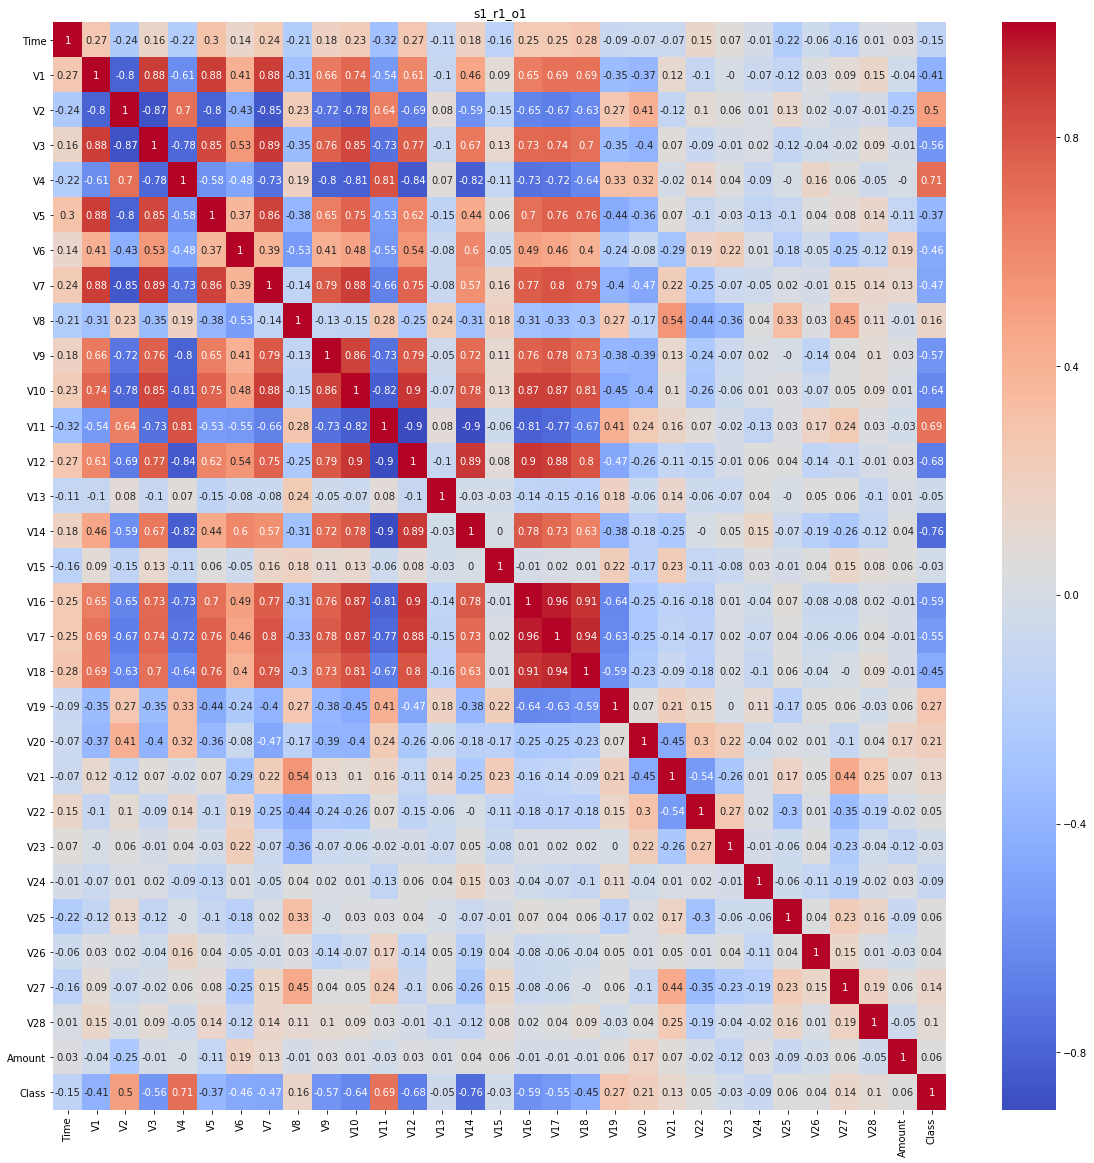

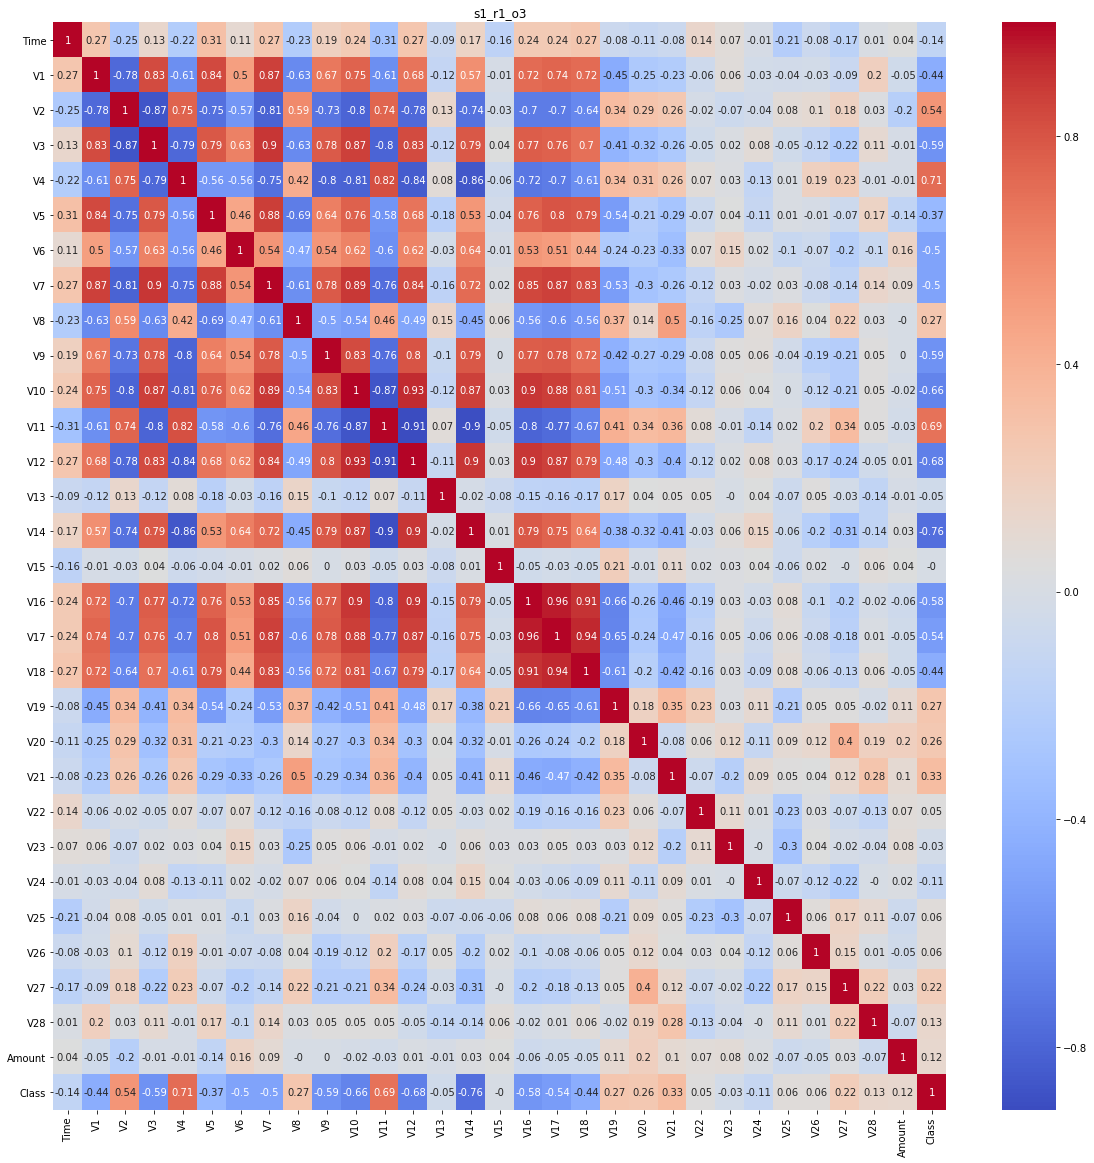

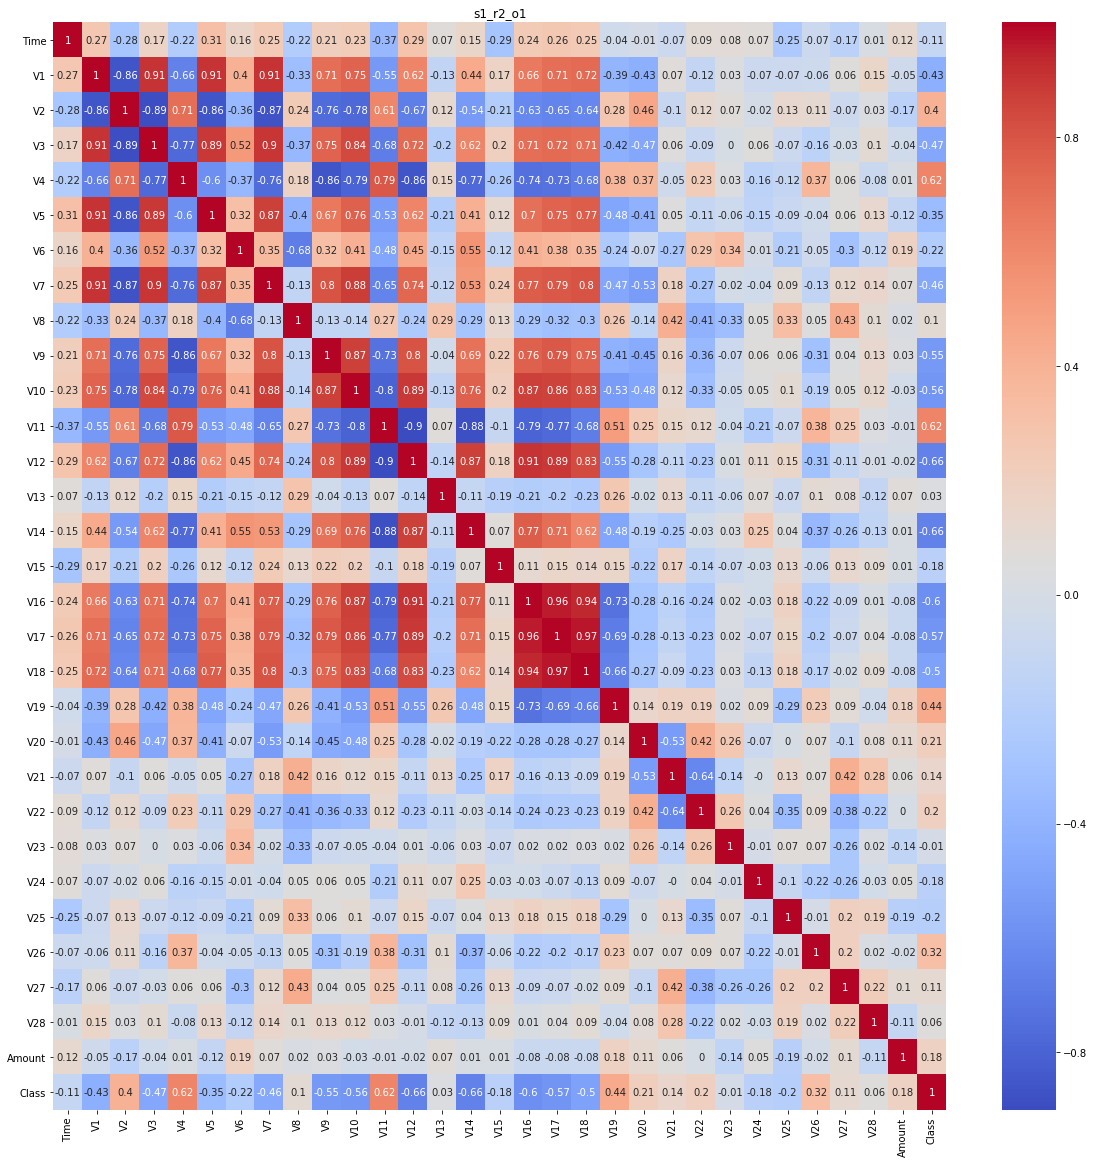

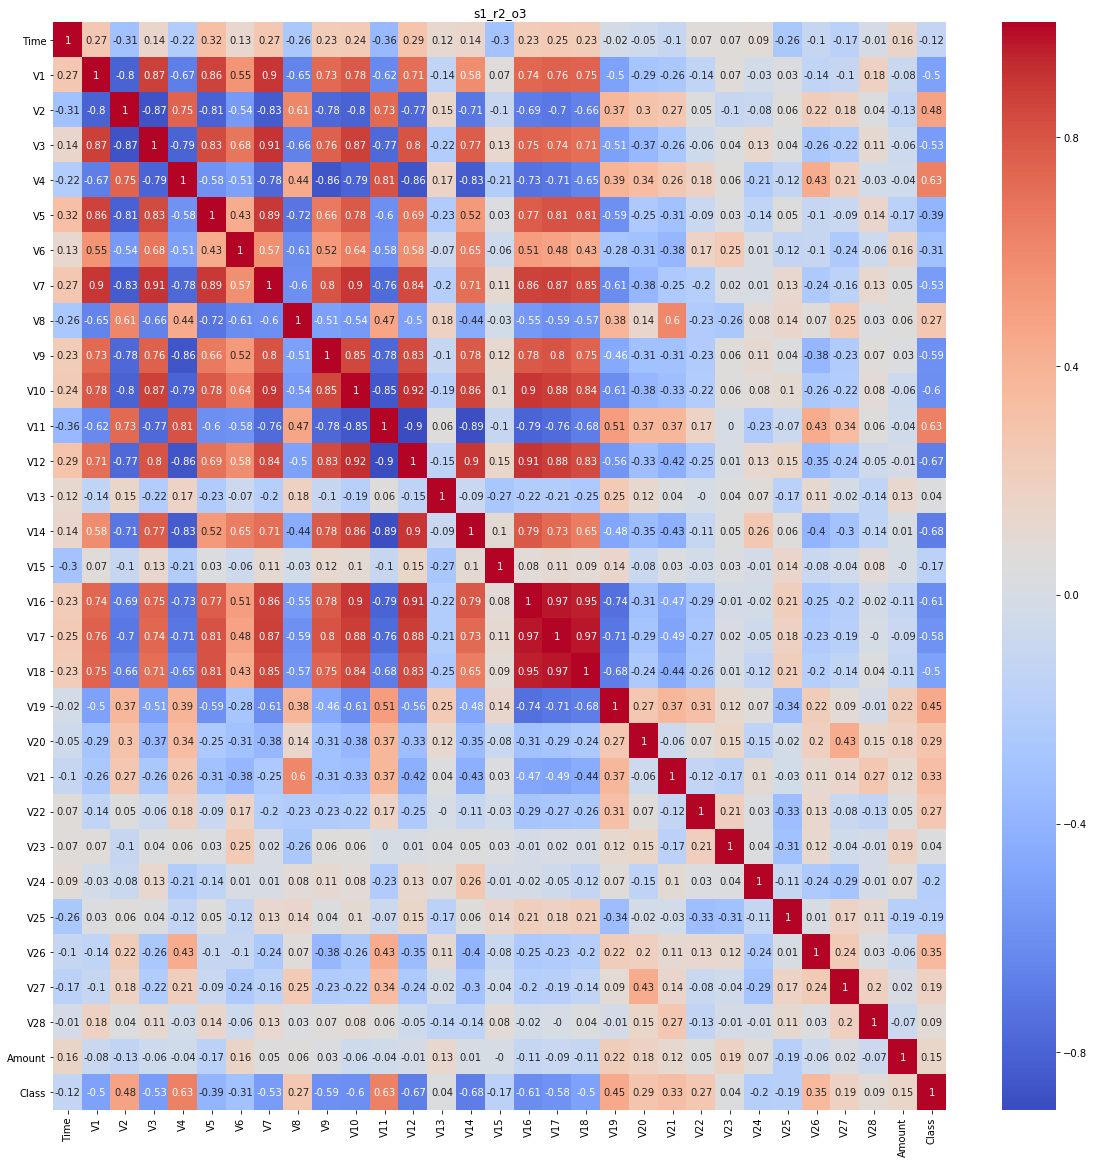

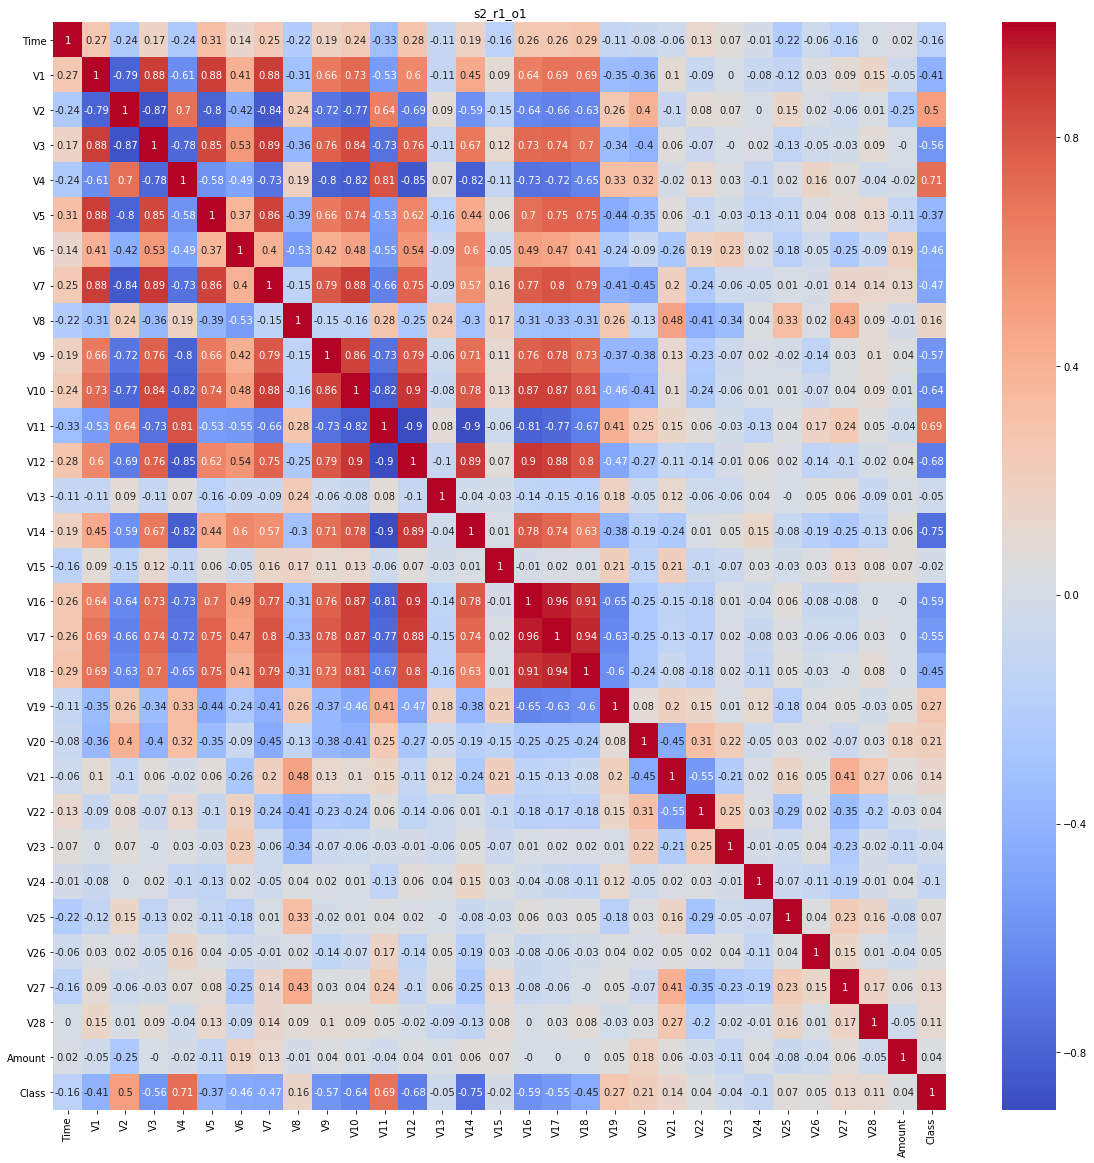

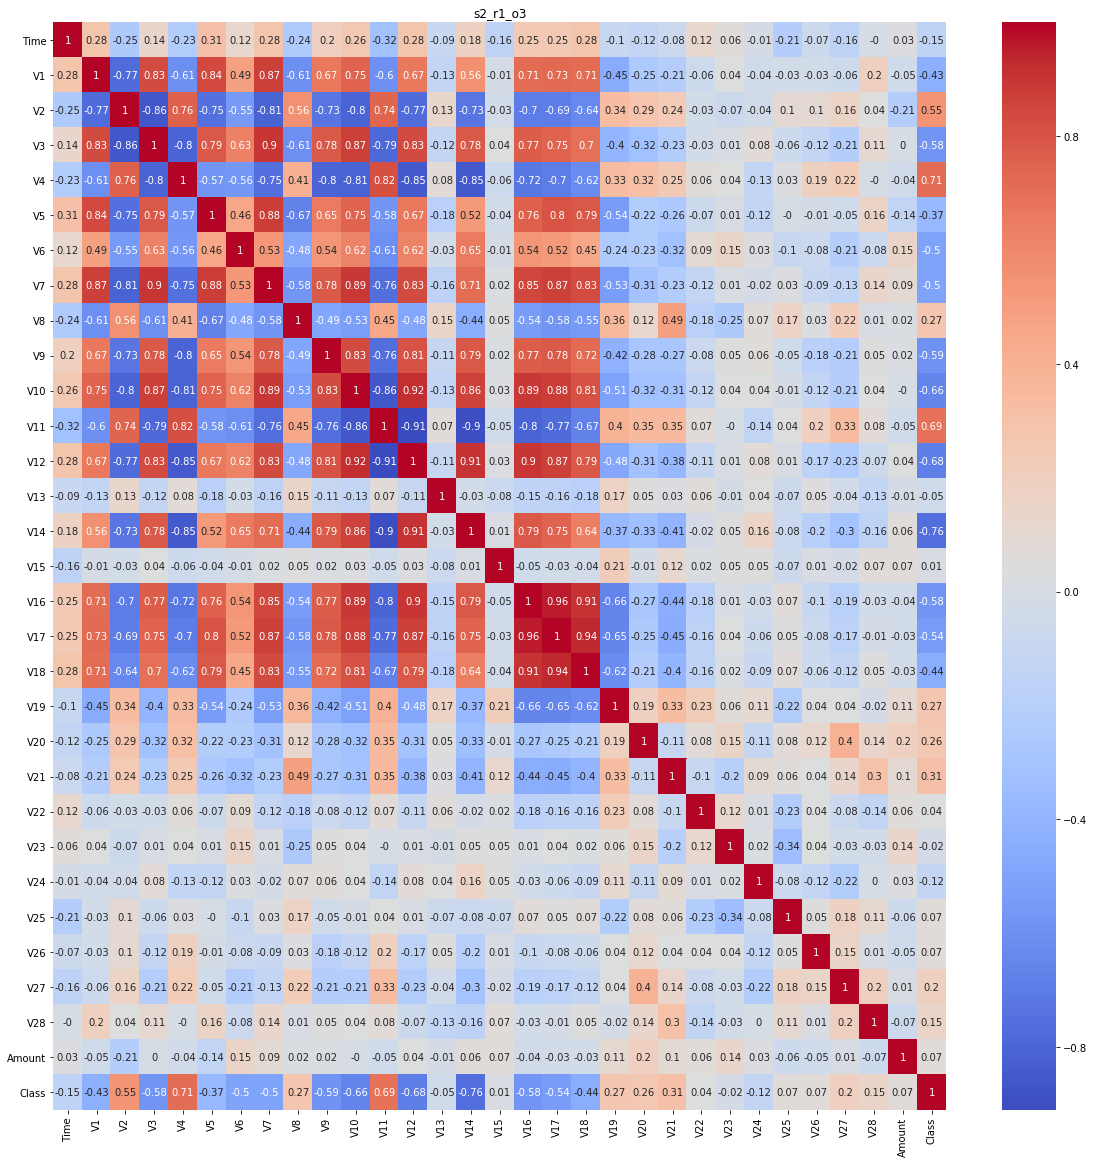

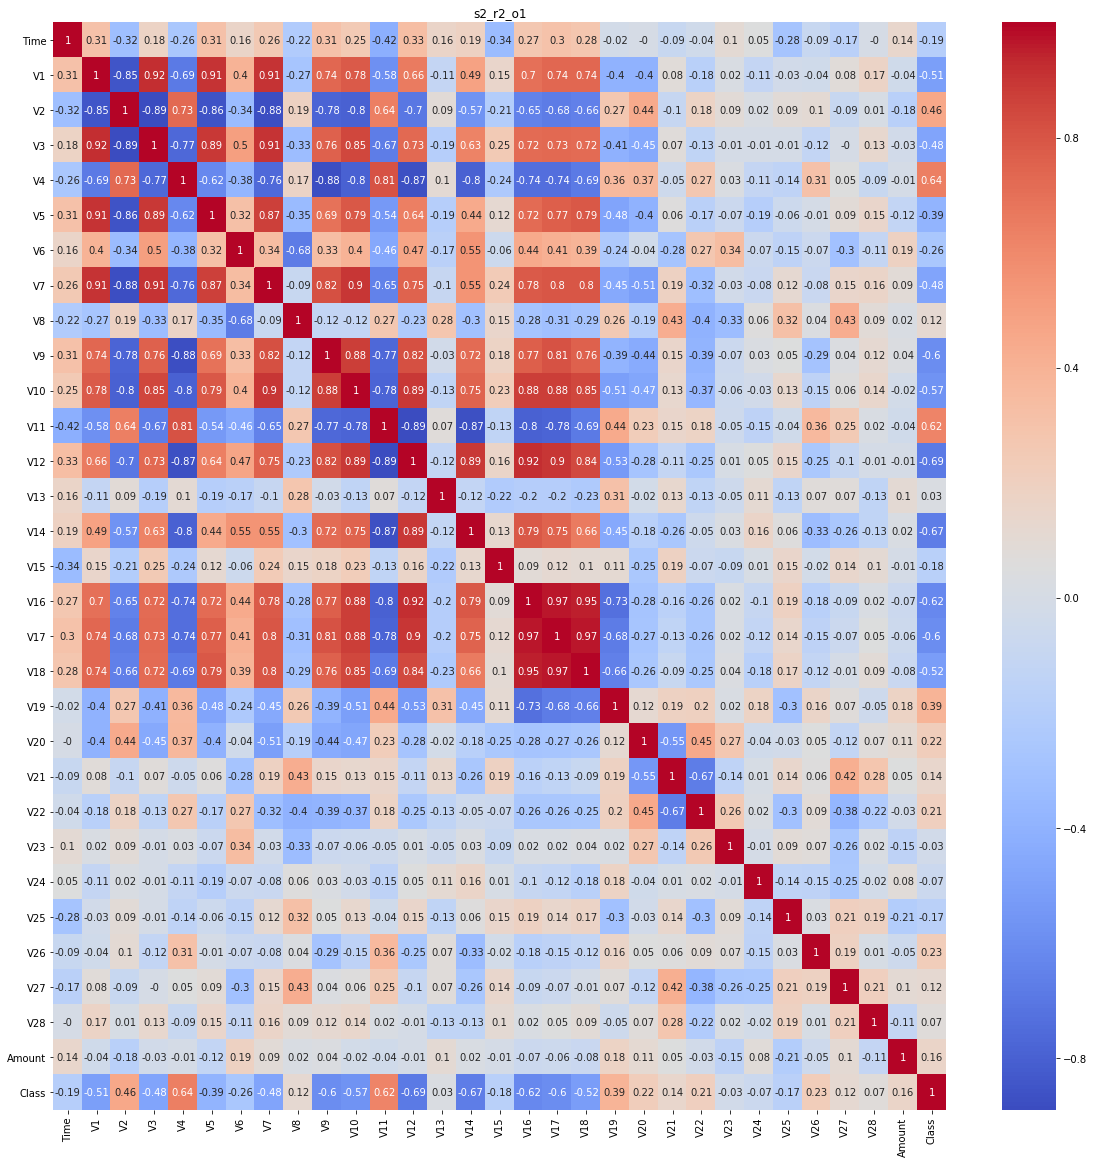

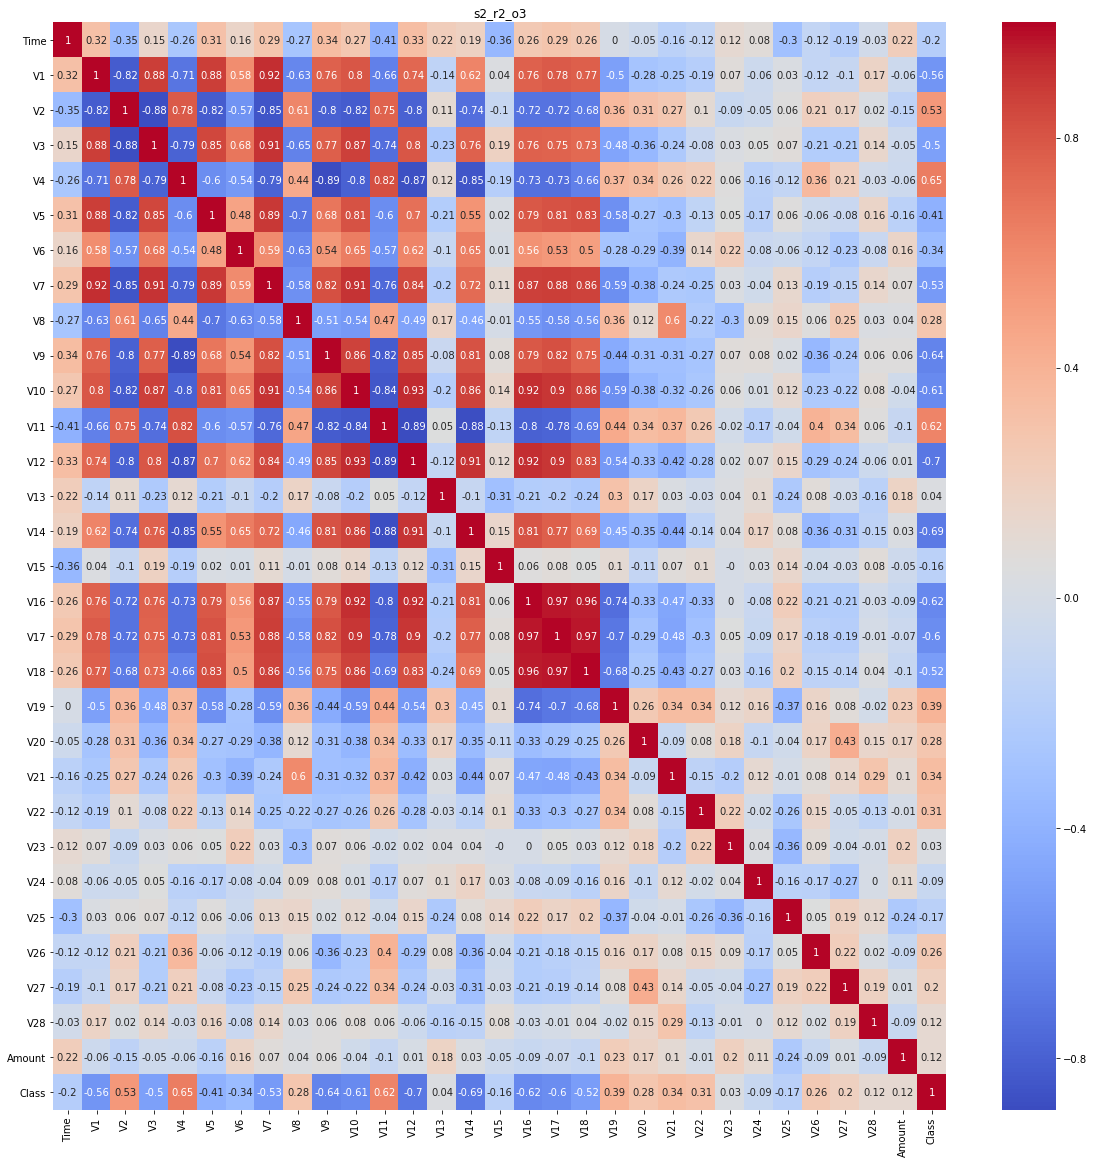

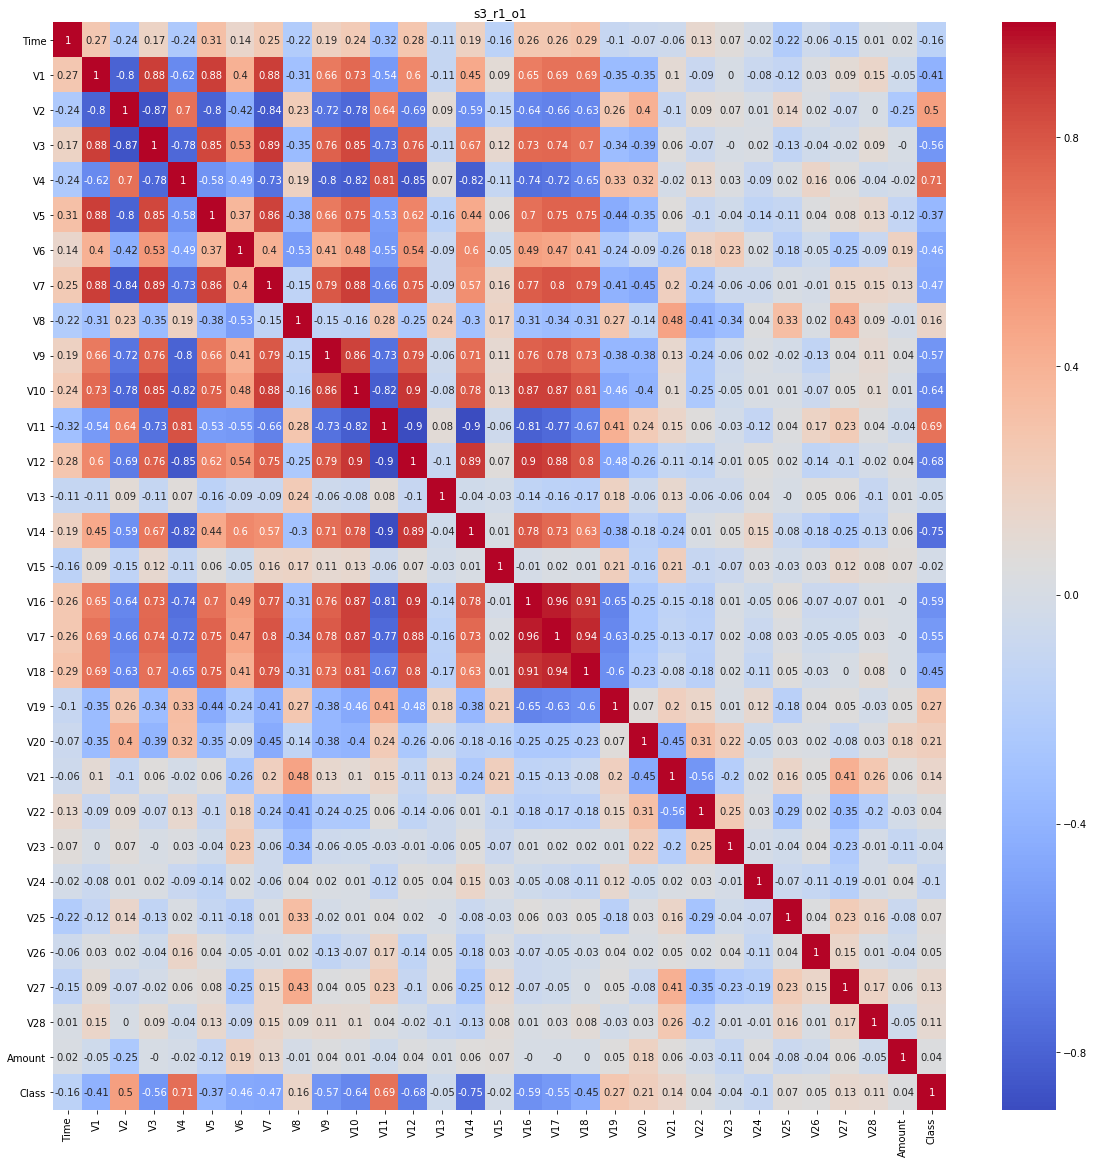

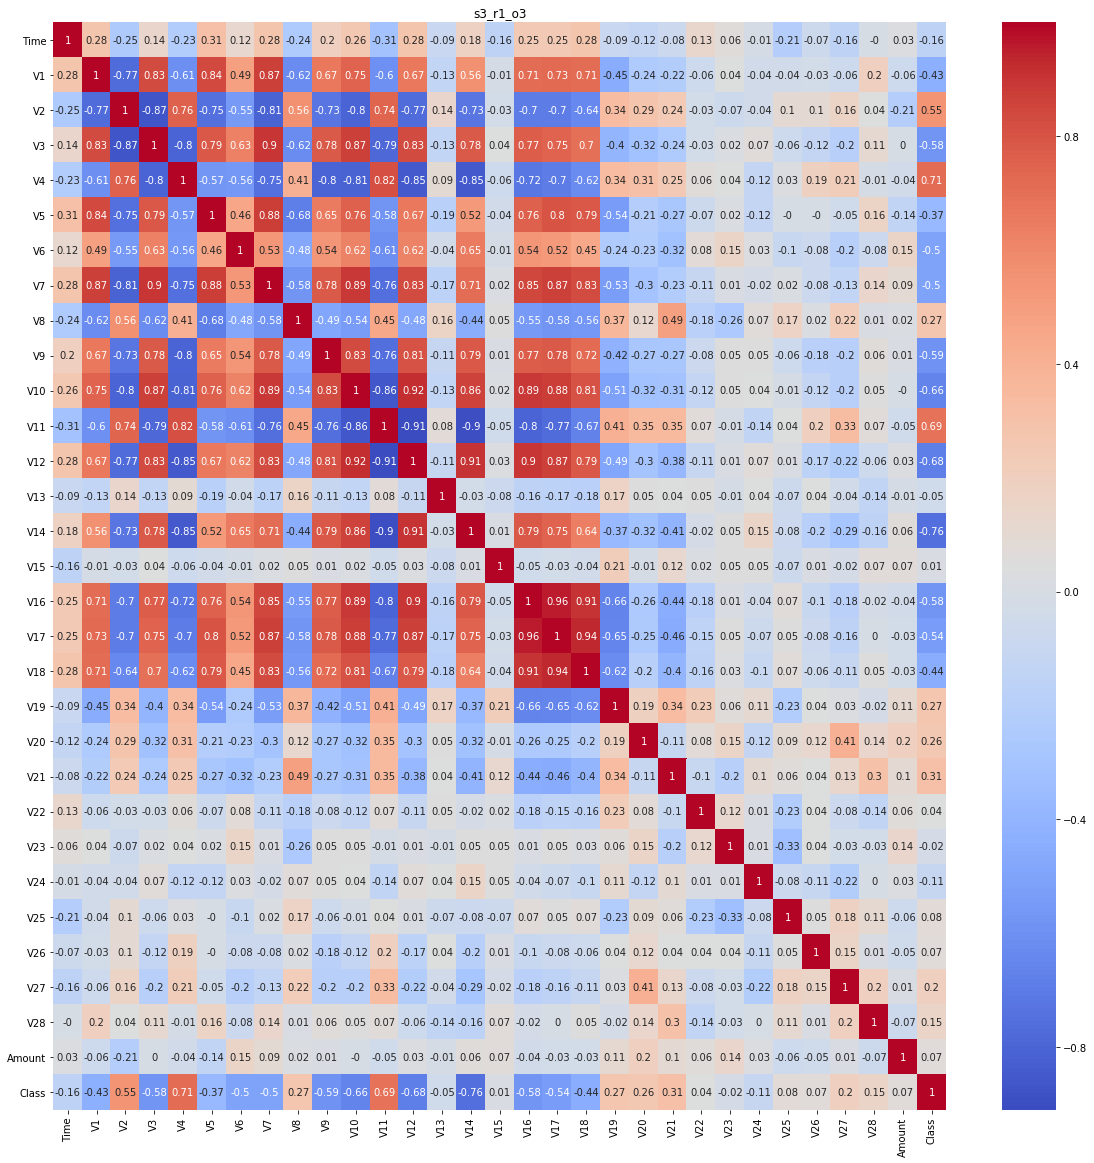

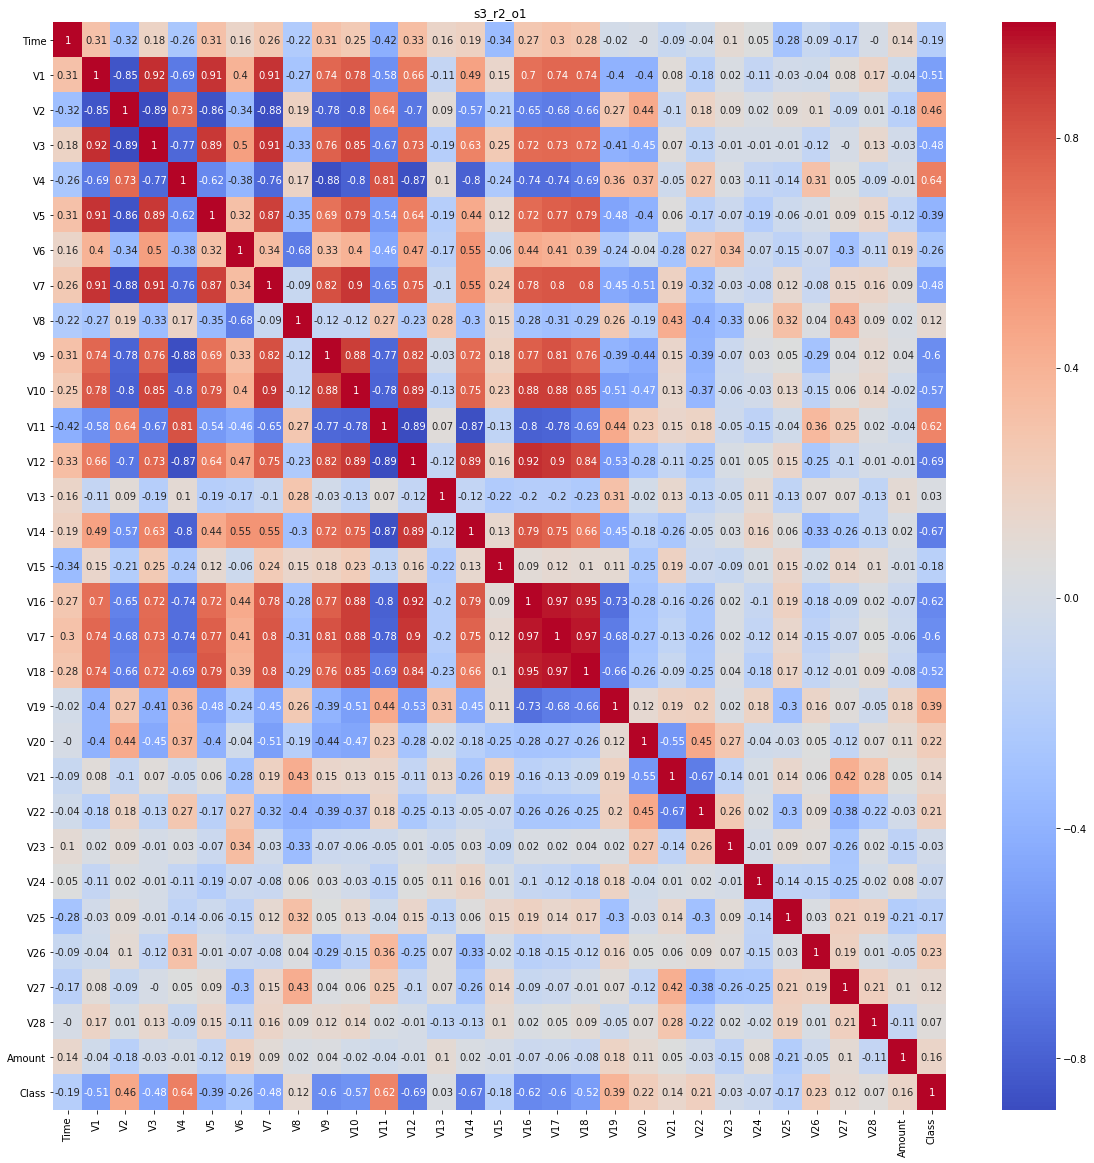

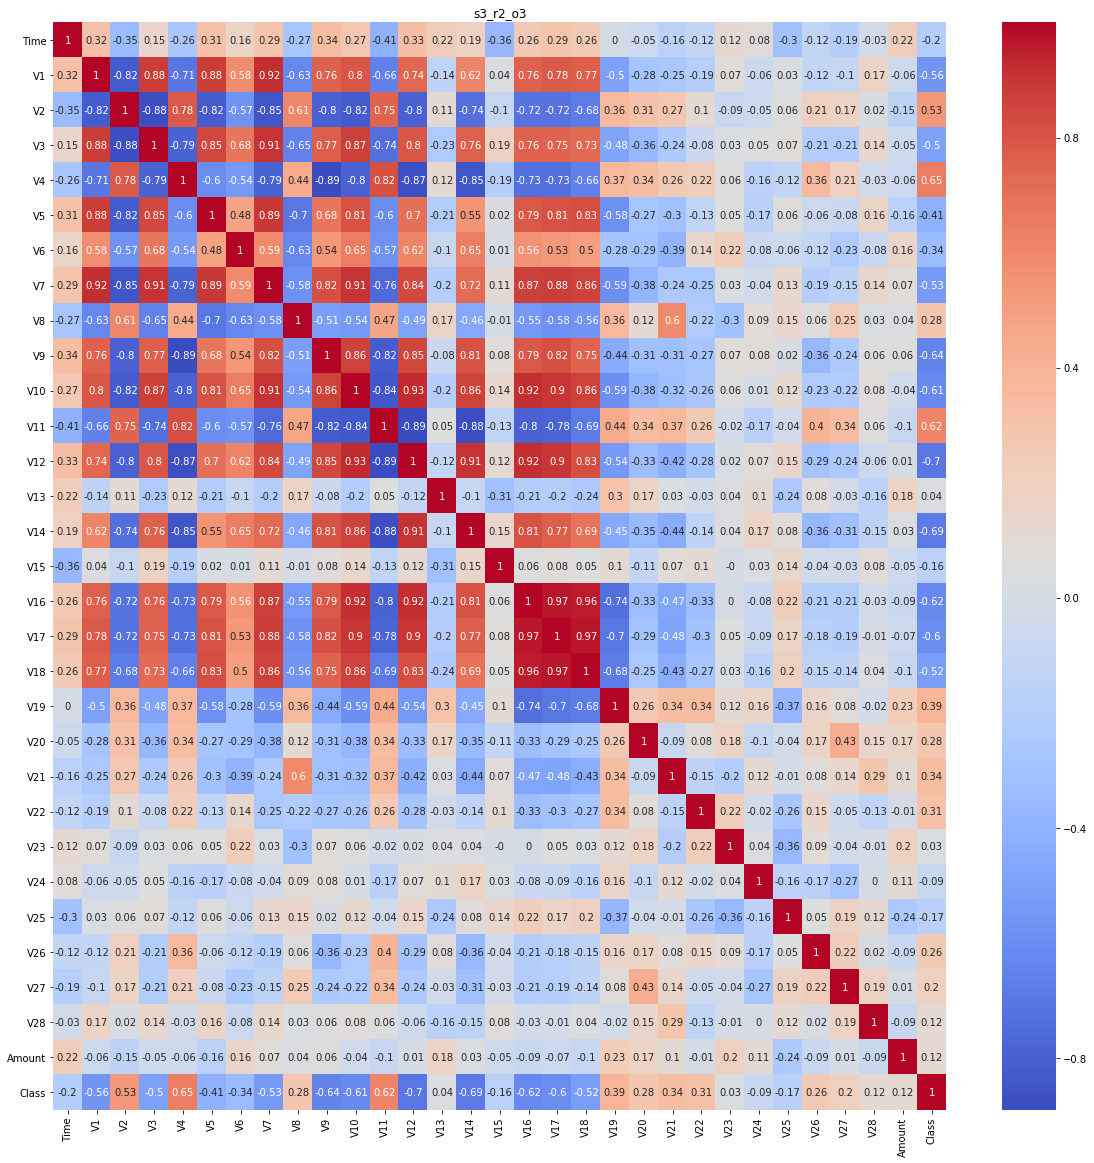

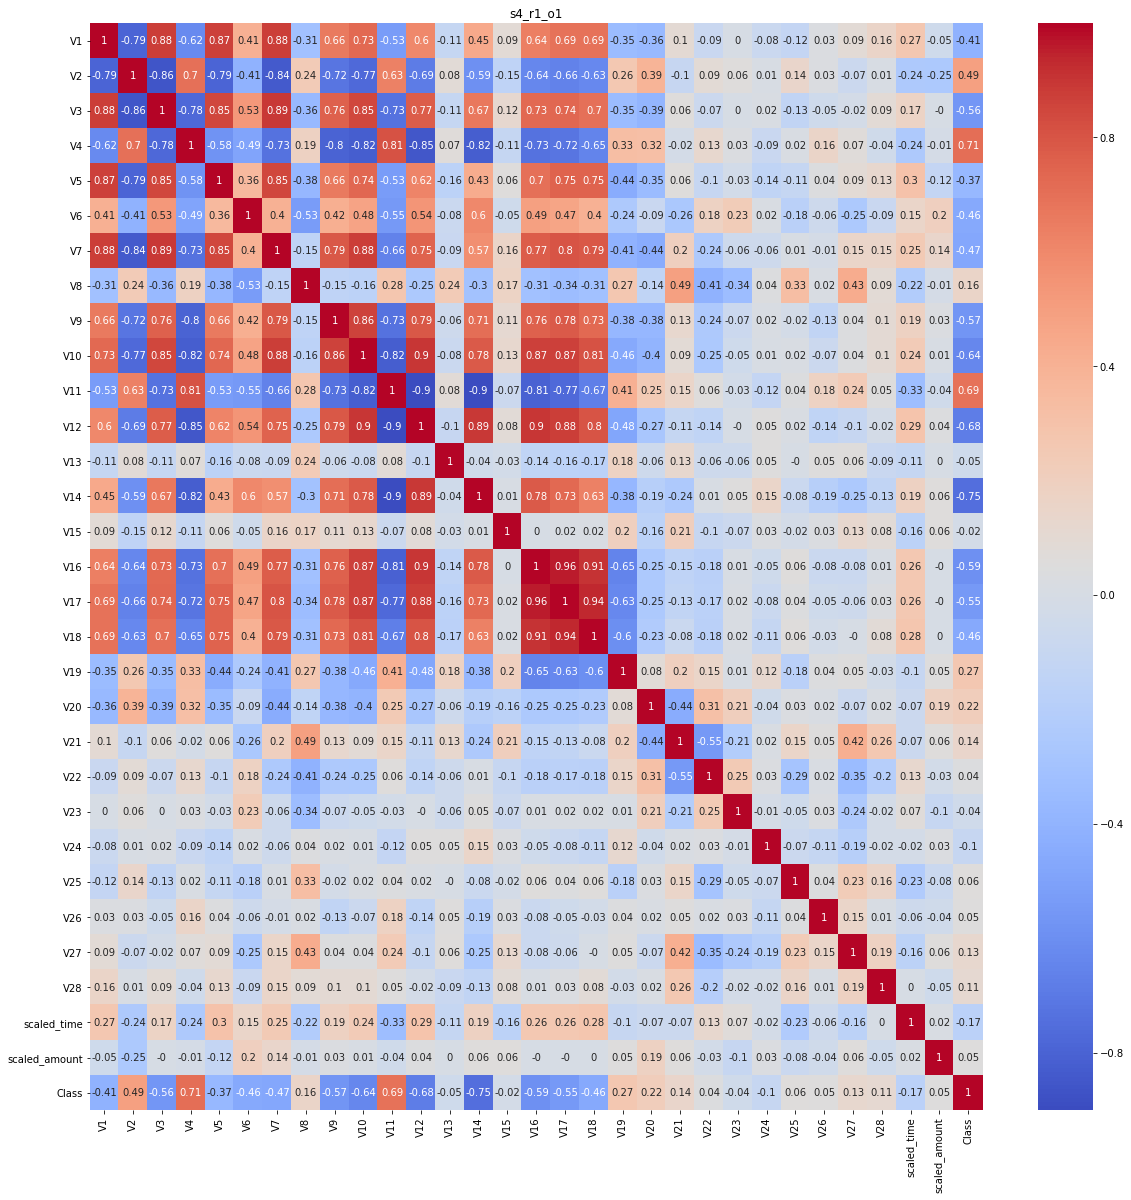

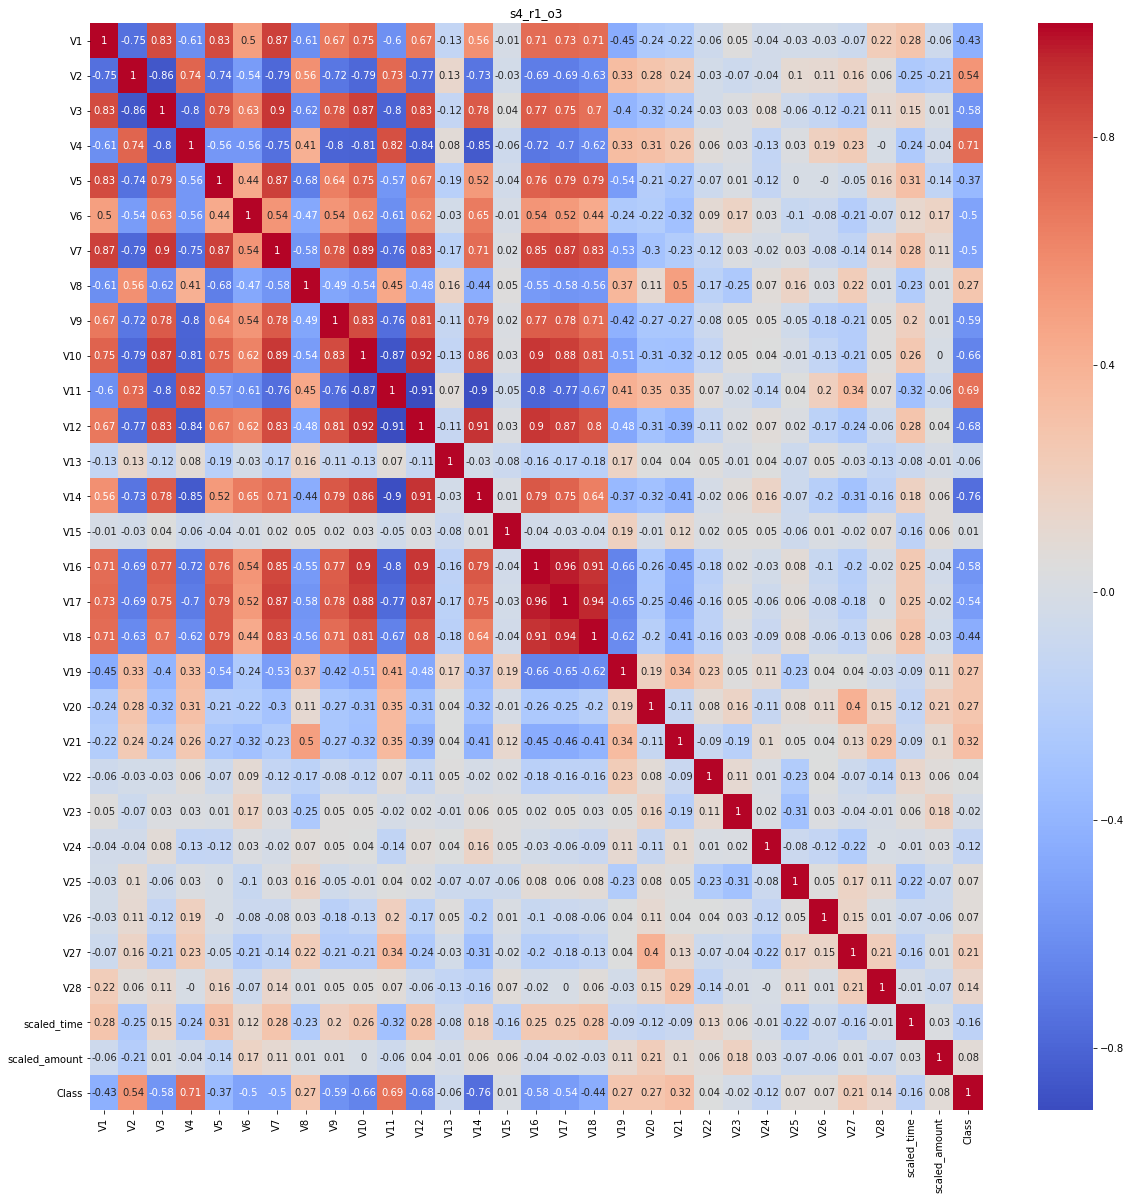

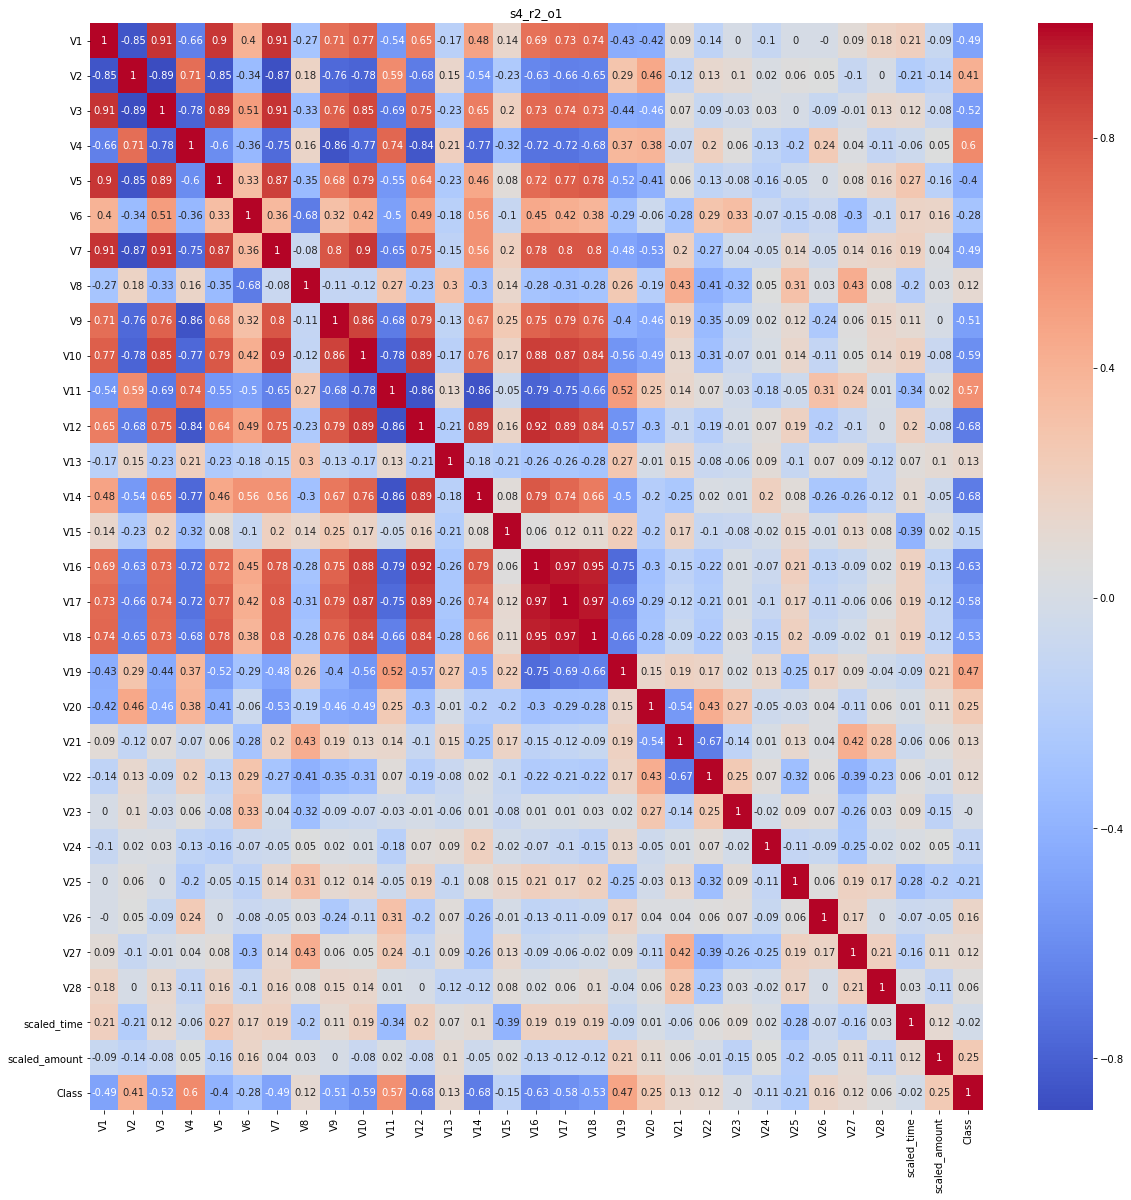

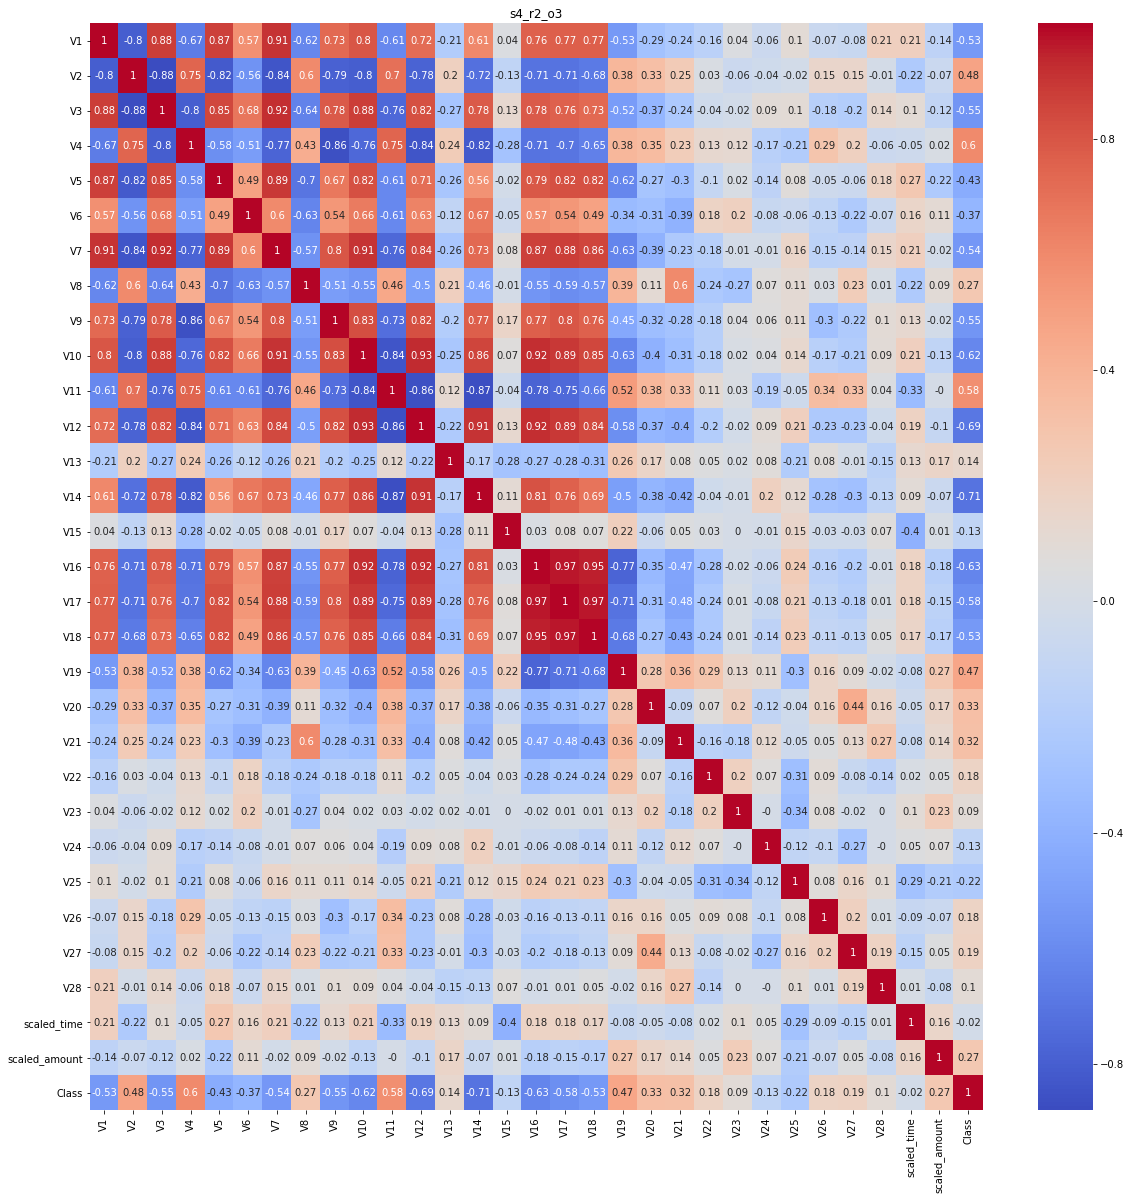

In [24]:
# Plot heatmaps for each version of the data
for key in sorted(outlier_removed_data.keys()):
    drawHeatMap(outlier_removed_data, key)

All versions of the data have multicolinarity. I will try to fix this with PCA.

#### Principal component analysis

In this section I will perform PCA on each of the 16 versions of the data. My process for each version of the data will be as follows: <br><br>
1) Create a range from 1 to the amount of total features minus 1 (29). <br>
2) Create an instance of the PCA class for each number in the range with the number of components set to the before mentioned number. <br>
4) Fit each PCA instance to the data. <br>
5) Find the sum of the total explained variance for each PCA instance. <br>
6) Plot the results <br>
7) Examine plots to see where they platue and select that many components.<br>
8) Record a list of components for each version of the data

I will be writing a function to do steps 1 through 6.

## PCA

## Matplotlib

In [37]:
# Function for steps 1 - 8
def PCA_Plot(key):
    
    # Get X
    X_= outlier_removed_data[key][0]
    
    # Create list to store sums of explained variance ratios
    evrs = []
    
    # Create a range from 1 to 29
    r = range(5,30)
    
    # Create an instance of the PCA class for each number in r
    for n in r:
        pca = PCA(n)
        
        # Fit pca to the data and transform
        X_pca = pca.fit_transform(X_)

        # Append the sum of explained variance ratio to the list "evrs"
        evrs.append(sum(pca.explained_variance_ratio_))
        
    # Plot the results
    plt.figure(figsize=(15,4))
    plt.plot(r, evrs, color='green', label='Sums of explained variance ratios')
    plt.title(key + ' Explained variance')
    plt.xlabel('Number of principle components')
    plt.xticks(r)
    plt.yticks(np.array(np.arange(round(evrs[0], 1)-0.1, 1.09, step=0.1)))
    plt.legend()
    plt.grid()
    plt.show()
    

Now I will manually go through each version and record where each graph plateus. I will use a list to record my observations.

Warning: this cell took 8 minutes to run!

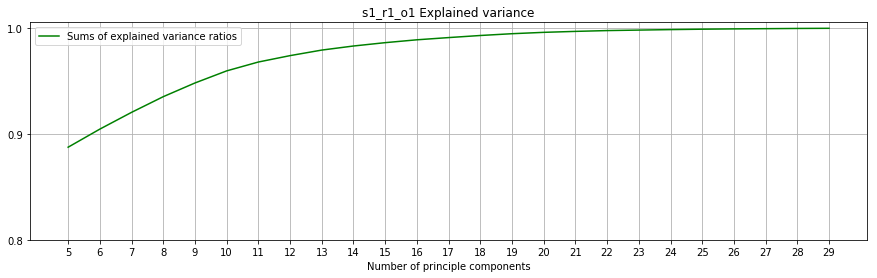

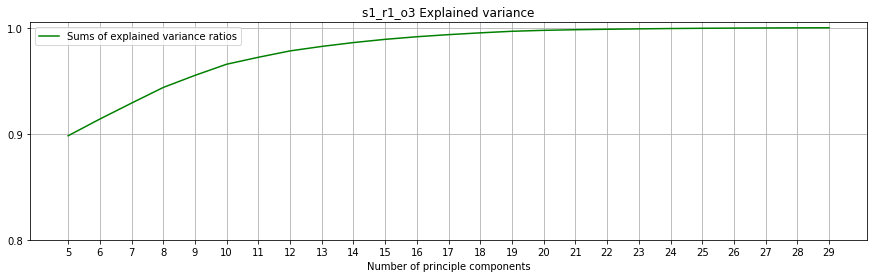

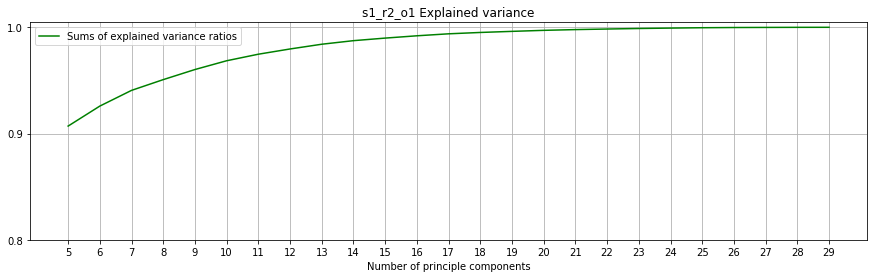

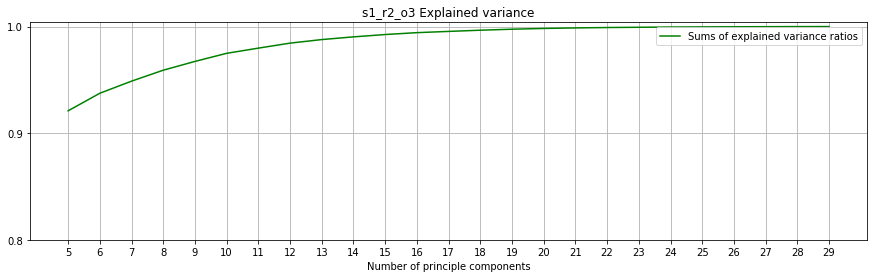

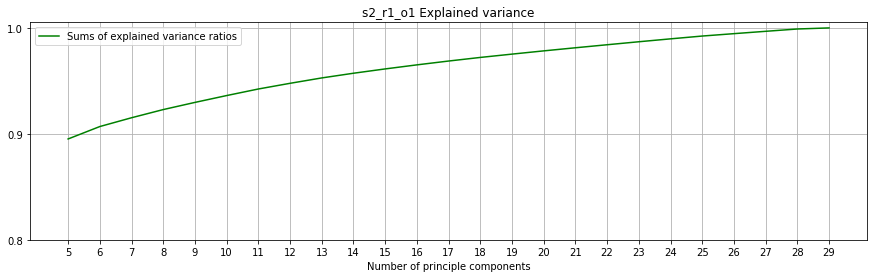

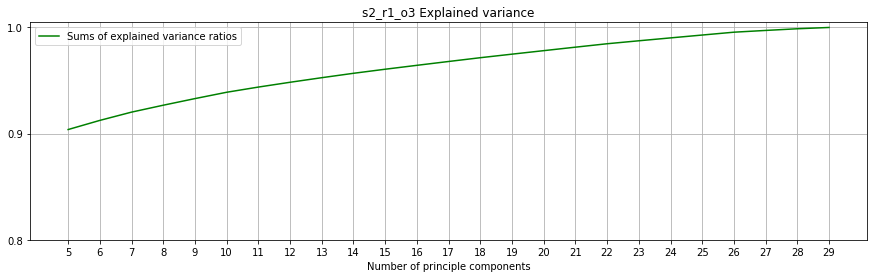

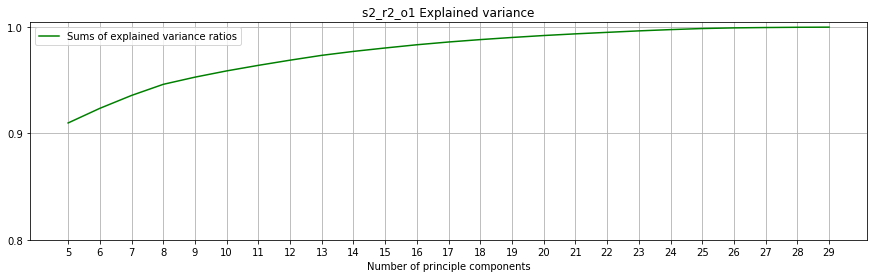

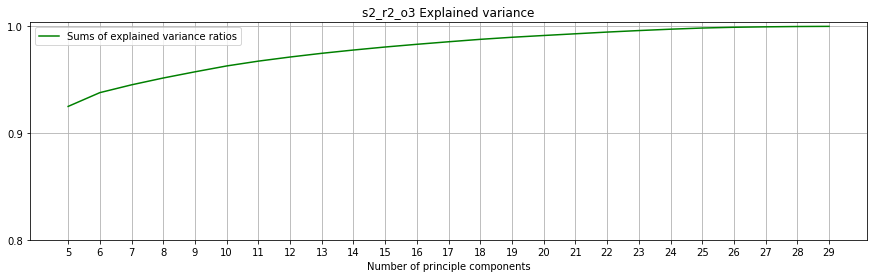

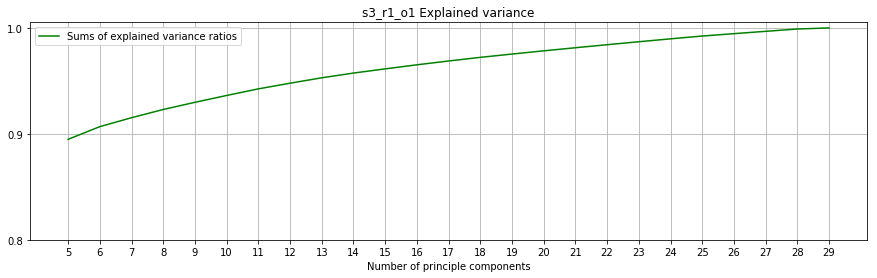

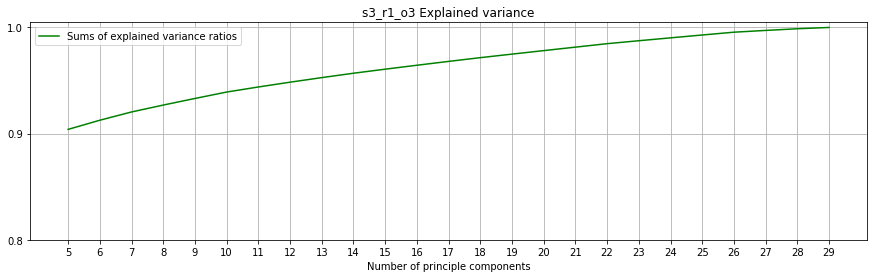

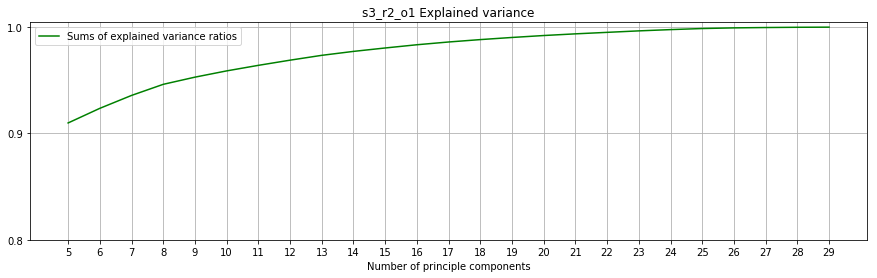

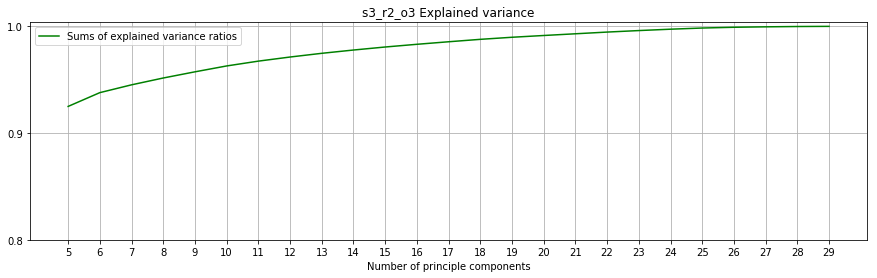

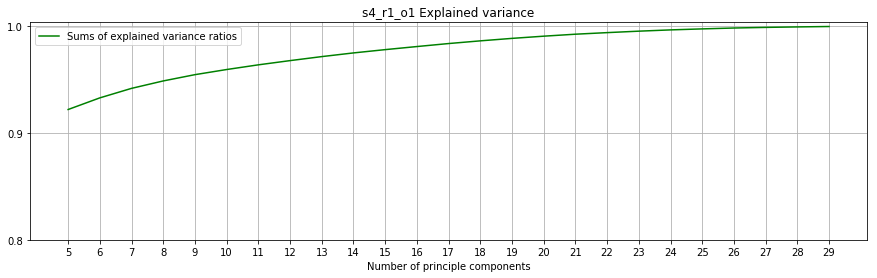

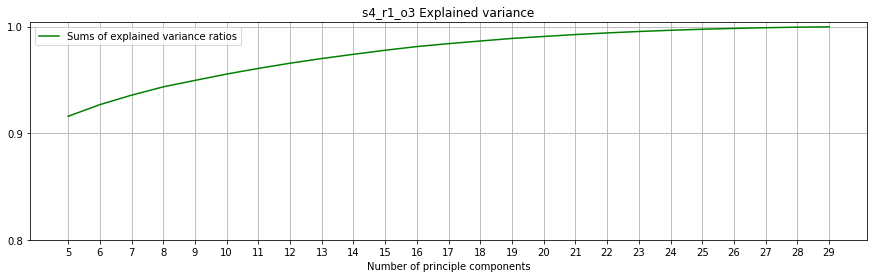

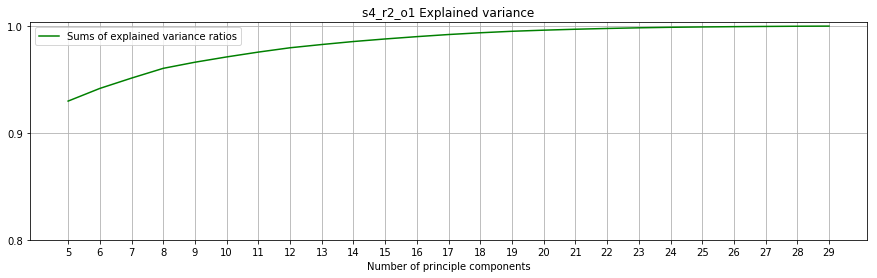

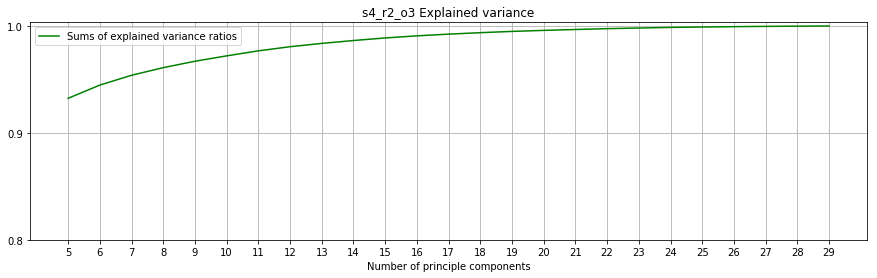

It took 479.029931306839 seconds for this cell to run


In [38]:
# Run function on every version of the data and time this cell

t1 = time.time()

for key in sorted(outlier_removed_data.keys()):
    PCA_Plot(key)
    
t2 = time.time()

print('It took {} seconds for this cell to run'.format(t2-t1))

In [39]:
# Number of components to use in order of sorted keys
n_components = [16, 16, 16, 15, 24, 25, 19, 20, 23, 24, 19, 18, 21, 22, 16, 18]

# zip sorted keys of outlier removed data with n_components
olr_keys_n_components = zip(sorted(outlier_removed_data.keys()), n_components)

In [40]:
# Save olr_keys_n_components
pickle_out = open("Modeling/olr_keys_n_components.pickle", "wb")
pickle.dump(olr_keys_n_components, pickle_out)
pickle_out.close()

Now for each key in outlier_removed_data I will create a key in a new dictionary (pc_data) where I will store a PCA transformed version of the train and test data. I will add a suffix '_p' to the data just in case to help keep things organized.

In [41]:
# Dictionary for PCA transformed data
pc_data = {}

In [42]:
# Create a suffix to add to each key
suffix = '_p'

# Iterate through our list of n_components and through the sorted keys of outlier_removed_data
for key, n in olr_keys_n_components
    
    # Retrieve data from outlier_removed_data
    X_ = outlier_removed_data[key][0]
    y_ = outlier_removed_data[key][1]
    
    # Create an instance of the PCA class with the right amount for n_components
    pca = PCA(n)
    
    # fit and transform data
    pc_X = pca.fit_transform(X_)
    
    # Turn data back into a dataframe
    pc_X = pd.DataFrame(pc_X, columns=range(n))

    
    # Add the newly transformed data too the dictionary pc_data
    pc_data[key + suffix] = (pc_X, y_)

SyntaxError: invalid syntax (<ipython-input-42-a46fa7c606fc>, line 5)

Now I will examine the PCA transformed data for multicolinearity.

In [ ]:
# Draw heat map for each version of the data with PCA
for key in sorted(pc_data.keys()):
    # Function from earlier to draw heat maps
    drawHeatMap(pc_data, key)

PCA removed all multicolinearity from the data and also lowered dimensionality!

## Sources
1) Stack Exchange post: https://datascience.stackexchange.com/questions/32818/train-test-split-of-unbalanced-dataset-classification<br>
2) Top Rated Kaggle Post: https://www.kaggle.com/janiobachmann/credit-fraud-dealing-with-imbalanced-datasets<br>
3) Scikit Learn Page: https://scikit-learn.org/stable/auto_examples/preprocessing/plot_all_scaling.html<br>
4) Microsoft Page on SMOTE: https://docs.microsoft.com/en-us/azure/machine-learning/studio-module-reference/smote<br>
5) GeeksForGeeks Page on NearMiss: https://www.geeksforgeeks.org/ml-handling-imbalanced-data-with-smote-and-near-miss-algorithm-in-python/ <br>
6) Blog Post on Removing Outliers: 'https://towardsdatascience.com/ways-to-detect-and-remove-the-outliers-404d16608dba